Idea: given a model architecture and all necessary parameters, train iteratively using LOSOXV and present final statistics in the forms of:

- confusion matrices
- learning curves
- final test accuracies and losses

For the subjects included in training/validation, perform the usual standardisation and normalisation. For the left out subjects, estimate their normalisation with respect to the mins and maxs extracted from the other subjects (to simulate real world scenario).

To take this even further - standardise for each window. 

In [4]:
import sys
sys.path.append('..')

from utils.constants import *
from utils.file_readers import *
from utils.data_exploration import *
from utils.signal_processing import *
from utils.sliding_window import *
from utils.stand_norm import *

import pandas as pd
import random

from sklearn import metrics
import seaborn as sns

In [5]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Conv1D, Dropout, MaxPooling1D, BatchNormalization
from keras import optimizers

In [3]:
data = pd.read_csv("../Preprocessed/raw_data.csv")

In [4]:
data.head(5)

,timestamp,seq,accel_x,accel_y,accel_z,accel_magnitude,accel_pca,subject,activity,correctness
0,1575566873410,0,-0.041016,-0.967773,0.093750,0.973168,0.014811,ron,6,correct
1,1575566873411,2,-0.044922,-1.047852,0.014648,1.048916,-0.043064,ron,6,correct
2,1575566873412,4,-0.027344,-0.976562,0.017578,0.977103,-0.051363,ron,6,correct
3,1575566873412,6,0.016602,-1.014648,-0.028320,1.015179,-0.115484,ron,6,correct
4,1575566873413,8,-0.015625,-1.026367,-0.033203,1.027023,-0.097935,ron,6,correct


Add the other columns in preparation for the new data.

In [5]:
data = data.reindex(columns=['timestamp', 'seq', 'accel_x', 'accel_y', 'accel_z',
                             'accel_magnitude', 'accel_pca',
                             'subject', 'activity', 'correctness',
                             'accel_x_standardised', 'accel_y_standardised', 'accel_z_standardised',
                             'accel_magnitude_standardised', 'accel_pca_standardised',
                             'accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised',
                             'accel_magnitude_normalised', 'accel_pca_normalised'])

In [6]:
data

,timestamp,seq,accel_x,accel_y,accel_z,accel_magnitude,accel_pca,subject,activity,correctness,accel_x_standardised,accel_y_standardised,accel_z_standardised,accel_magnitude_standardised,accel_pca_standardised,accel_x_normalised,accel_y_normalised,accel_z_normalised,accel_magnitude_normalised,accel_pca_normalised
0,1575566873410,0,-0.041016,-0.967773,0.093750,0.973168,0.014811,ron,6,correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1575566873411,2,-0.044922,-1.047852,0.014648,1.048916,-0.043064,ron,6,correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1575566873412,4,-0.027344,-0.976562,0.017578,0.977103,-0.051363,ron,6,correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1575566873412,6,0.016602,-1.014648,-0.028320,1.015179,-0.115484,ron,6,correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1575566873413,8,-0.015625,-1.026367,-0.033203,1.027023,-0.097935,ron,6,correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126462,1574270078523,1140,-0.039062,-0.991211,0.018555,0.992154,0.255054,andrius,7,incorrect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126463,1574270078524,1142,-0.059570,-0.852539,0.073242,0.857750,0.207447,andrius,7,incorrect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126464,1574270078525,1144,0.044922,-0.928711,0.091797,0.934317,0.143565,andrius,7,incorrect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126465,1574270078525,1146,0.051758,-0.919922,0.077148,0.924601,0.151630,andrius,7,incorrect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Set seed for experiment reproducibility

In [7]:
random.seed(42)

For each subject to be left out, generate the training and validation sets (keeping them random).

In [8]:
subjects = get_subject_names()


In [9]:
for i in range(len(subjects)):
    
    # early stopping for testing
    if i > 1:
        break
    
    # generate training, validation and test subjects
    
    left_out_subject = subjects[i]
    print("Left out subject = {}".format(subjects[i]))
    
    rng = generate_range(i, n_subjects)
    
    test_subjects = set()
    while(len(test_subjects) < n_test_subjects):
        choice = random.choice(rng)
        test_subjects.add(choice)
    
    # for validation, take the remaining ones
    valid_subjects = [subjects[j] for j in (set(rng) - test_subjects)]
    
    test_subjects = [subjects[j] for j in test_subjects]
    
    print("Test subjects = {}".format(test_subjects))
    print("Validation subjects = {}".format(valid_subjects))

Left out subject = adela


NameError: name 'generate_range' is not defined

Test the stand_norm functions

In [10]:
data_clean, means_by_act, std_by_act = remove_outliers(data, activities='all', subjects=['teo', 'ron', 'andrius'], correctness='correct')

Original dataframe length = 29195
New dataframe length = 29055
Removed 140 outliers


In [ ]:
std_by_act

In [ ]:
data_clean, means_by_act, std_by_act = remove_outliers(data, activities='all', subjects=['teo', 'ron', 'andrius', 'adela'], correctness='correct')

In [ ]:
std_by_act

Maybe a function to write these to a csv file? 

In [ ]:
data_std = standardise_data(data_clean, activities='all', subjects=['teo', 'ron', 'andrius', 'adela'], correctness='correct')

In [ ]:
mask = mask = (data_std['subject'] == 'teo') & (data_std['activity'] == 1) & (data_std['correctness'] == 'correct')
plt.plot(data_std[mask]['accel_pca'])
plt.title("Before standardisation")

In [ ]:
plt.plot(data_std[mask]['accel_pca_standardised'])
plt.title("After standardisation")

In [ ]:
data_norm = normalise_data(data_std, activities='all', subjects=['teo', 'ron', 'andrius', 'adela'], correctness='correct')

In [ ]:
plt.plot(data_norm[mask]['accel_magnitude_normalised'])

I can see that there are definitely some changes when you have fewer subjects to estimate this on, which is good, it means that the functions are working. Next, do this for each left out subject.

### LOSOXV

In [50]:
def generate_range(n, end, start=0):
    return list(range(start, n)) + list(range(n+1, end))

In [51]:
data = pd.read_csv("../Preprocessed/raw_data.csv")
data = data.reindex(columns=['timestamp', 'seq', 'accel_x', 'accel_y', 'accel_z',
                             'accel_magnitude', 'accel_pca',
                             'subject', 'activity', 'correctness',
                             'accel_x_standardised', 'accel_y_standardised', 'accel_z_standardised',
                             'accel_magnitude_standardised', 'accel_pca_standardised',
                             'accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised',
                             'accel_magnitude_normalised', 'accel_pca_normalised'])

random.seed(42)

In [52]:
subjects = get_subject_names()
n_subjects = len(subjects)

n_train_subjects = 12
n_validation_subjects = 2

In [53]:
activities = 'all'
correctness = 'correct'

In [54]:
n_time_steps = 38
step = 19
n_features = 3

In [55]:
features = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']

In [56]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 10

In [57]:
def initialise_model():
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation, input_shape=(n_time_steps, n_features)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [58]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

# train model
batch_size = 32
epochs = 500

In [59]:
# dictionaries for statistics
# they will all have keys = left out subject and value = stats 
cm = {}
histories = {}

In [60]:
# dataframe for statistics
losoxv_stats = pd.DataFrame(index=subjects, columns=['train_acc', 'train_loss',
                                                    'valid_acc', 'valid_loss',
                                                    'test_acc', 'test_loss'])

In [61]:
save_path = "../Plots/06_LOSOXV/"

Left out subject = adela
Test subjects = ['aggie', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'seb', 'sharan', 'teo']
Validation subjects = ['lukasz', 'zoe']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 117502
New dataframe length = 116737
Removed 765 outliers
Original dataframe length = 8965
New dataframe length = 8895
Removed 70 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
------------------

Epoch 78/500
1876/1876 [==============================] - 1s 702us/step - loss: 1.3292 - accuracy: 0.6375 - mse: 0.0583 - val_loss: 1.3426 - val_accuracy: 0.5777 - val_mse: 0.0587
Epoch 79/500
1876/1876 [==============================] - 1s 713us/step - loss: 1.3187 - accuracy: 0.6471 - mse: 0.0580 - val_loss: 1.3323 - val_accuracy: 0.5878 - val_mse: 0.0583
Epoch 80/500
1876/1876 [==============================] - 1s 723us/step - loss: 1.3077 - accuracy: 0.6434 - mse: 0.0576 - val_loss: 1.3227 - val_accuracy: 0.5912 - val_mse: 0.0580
Epoch 81/500
1876/1876 [==============================] - 1s 718us/step - loss: 1.2972 - accuracy: 0.6509 - mse: 0.0572 - val_loss: 1.3123 - val_accuracy: 0.5946 - val_mse: 0.0576
Epoch 82/500
1876/1876 [==============================] - 1s 695us/step - loss: 1.2873 - accuracy: 0.6525 - mse: 0.0568 - val_loss: 1.3026 - val_accuracy: 0.5980 - val_mse: 0.0573
Epoch 83/500
1876/1876 [==============================] - 1s 691us/step - loss: 1.2774 - accuracy: 0

1876/1876 [==============================] - 1s 732us/step - loss: 0.7451 - accuracy: 0.8070 - mse: 0.0341 - val_loss: 0.7954 - val_accuracy: 0.7703 - val_mse: 0.0357
Epoch 169/500
1876/1876 [==============================] - 1s 702us/step - loss: 0.7401 - accuracy: 0.8038 - mse: 0.0340 - val_loss: 0.7928 - val_accuracy: 0.7703 - val_mse: 0.0356
Epoch 170/500
1876/1876 [==============================] - 1s 716us/step - loss: 0.7431 - accuracy: 0.8033 - mse: 0.0342 - val_loss: 0.7901 - val_accuracy: 0.7736 - val_mse: 0.0355
Epoch 171/500
1876/1876 [==============================] - 1s 710us/step - loss: 0.7323 - accuracy: 0.8060 - mse: 0.0337 - val_loss: 0.7872 - val_accuracy: 0.7804 - val_mse: 0.0353
Epoch 172/500
1876/1876 [==============================] - 1s 700us/step - loss: 0.7272 - accuracy: 0.8124 - mse: 0.0333 - val_loss: 0.7839 - val_accuracy: 0.7838 - val_mse: 0.0352
Epoch 173/500
1876/1876 [==============================] - 1s 715us/step - loss: 0.7283 - accuracy: 0.8124 - 

1876/1876 [==============================] - 2s 908us/step - loss: 0.5580 - accuracy: 0.8465 - mse: 0.0260 - val_loss: 0.6323 - val_accuracy: 0.8277 - val_mse: 0.0286
Epoch 259/500
1876/1876 [==============================] - 2s 804us/step - loss: 0.5663 - accuracy: 0.8502 - mse: 0.0264 - val_loss: 0.6310 - val_accuracy: 0.8277 - val_mse: 0.0285
Epoch 260/500
1876/1876 [==============================] - 1s 771us/step - loss: 0.5558 - accuracy: 0.8529 - mse: 0.0259 - val_loss: 0.6302 - val_accuracy: 0.8311 - val_mse: 0.0285
Epoch 261/500
1876/1876 [==============================] - 2s 938us/step - loss: 0.5440 - accuracy: 0.8518 - mse: 0.0254 - val_loss: 0.6296 - val_accuracy: 0.8311 - val_mse: 0.0285
Epoch 262/500
1876/1876 [==============================] - 2s 893us/step - loss: 0.5485 - accuracy: 0.8566 - mse: 0.0256 - val_loss: 0.6282 - val_accuracy: 0.8311 - val_mse: 0.0284
Epoch 263/500
1876/1876 [==============================] - 1s 767us/step - loss: 0.5486 - accuracy: 0.8529 - 

1876/1876 [==============================] - 1s 700us/step - loss: 0.4583 - accuracy: 0.8838 - mse: 0.0213 - val_loss: 0.5540 - val_accuracy: 0.8514 - val_mse: 0.0251
Epoch 349/500
1876/1876 [==============================] - 1s 717us/step - loss: 0.4516 - accuracy: 0.8902 - mse: 0.0210 - val_loss: 0.5535 - val_accuracy: 0.8446 - val_mse: 0.0251
Epoch 350/500
1876/1876 [==============================] - 1s 718us/step - loss: 0.4480 - accuracy: 0.8881 - mse: 0.0209 - val_loss: 0.5526 - val_accuracy: 0.8480 - val_mse: 0.0250
Epoch 351/500
1876/1876 [==============================] - 1s 692us/step - loss: 0.4521 - accuracy: 0.8854 - mse: 0.0211 - val_loss: 0.5525 - val_accuracy: 0.8514 - val_mse: 0.0250
Epoch 352/500
1876/1876 [==============================] - 1s 692us/step - loss: 0.4532 - accuracy: 0.8870 - mse: 0.0213 - val_loss: 0.5519 - val_accuracy: 0.8547 - val_mse: 0.0250
Epoch 353/500
1876/1876 [==============================] - 1s 704us/step - loss: 0.4431 - accuracy: 0.8881 - 

1876/1876 [==============================] - 2s 811us/step - loss: 0.3834 - accuracy: 0.9062 - mse: 0.0178 - val_loss: 0.5057 - val_accuracy: 0.8682 - val_mse: 0.0228
Epoch 439/500
1876/1876 [==============================] - 1s 751us/step - loss: 0.3905 - accuracy: 0.8998 - mse: 0.0182 - val_loss: 0.5053 - val_accuracy: 0.8682 - val_mse: 0.0228
Epoch 440/500
1876/1876 [==============================] - 2s 832us/step - loss: 0.3891 - accuracy: 0.9003 - mse: 0.0182 - val_loss: 0.5054 - val_accuracy: 0.8682 - val_mse: 0.0228
Epoch 441/500
1876/1876 [==============================] - 2s 1ms/step - loss: 0.3998 - accuracy: 0.8982 - mse: 0.0188 - val_loss: 0.5048 - val_accuracy: 0.8682 - val_mse: 0.0228
Epoch 442/500
1876/1876 [==============================] - 2s 993us/step - loss: 0.3889 - accuracy: 0.8993 - mse: 0.0182 - val_loss: 0.5044 - val_accuracy: 0.8682 - val_mse: 0.0227
Epoch 443/500
1876/1876 [==============================] - 2s 964us/step - loss: 0.3833 - accuracy: 0.9083 - ms

1821/1821 [==============================] - 1s 737us/step - loss: 2.1685 - accuracy: 0.2125 - mse: 0.0868 - val_loss: 2.1818 - val_accuracy: 0.2266 - val_mse: 0.0870
Epoch 14/500
1821/1821 [==============================] - 1s 731us/step - loss: 2.1544 - accuracy: 0.2169 - mse: 0.0864 - val_loss: 2.1679 - val_accuracy: 0.2292 - val_mse: 0.0866
Epoch 15/500
1821/1821 [==============================] - 1s 816us/step - loss: 2.1417 - accuracy: 0.2339 - mse: 0.0860 - val_loss: 2.1547 - val_accuracy: 0.2344 - val_mse: 0.0862
Epoch 16/500
1821/1821 [==============================] - 2s 894us/step - loss: 2.1296 - accuracy: 0.2378 - mse: 0.0857 - val_loss: 2.1426 - val_accuracy: 0.2448 - val_mse: 0.0858
Epoch 17/500
1821/1821 [==============================] - 2s 1ms/step - loss: 2.1172 - accuracy: 0.2433 - mse: 0.0853 - val_loss: 2.1309 - val_accuracy: 0.2578 - val_mse: 0.0854
Epoch 18/500
1821/1821 [==============================] - 2s 837us/step - loss: 2.1051 - accuracy: 0.2515 - mse: 0.

Epoch 59/500
1821/1821 [==============================] - 1s 779us/step - loss: 1.7237 - accuracy: 0.4415 - mse: 0.0723 - val_loss: 1.7752 - val_accuracy: 0.3828 - val_mse: 0.0737
Epoch 60/500
1821/1821 [==============================] - 1s 800us/step - loss: 1.7157 - accuracy: 0.4509 - mse: 0.0720 - val_loss: 1.7674 - val_accuracy: 0.3958 - val_mse: 0.0735
Epoch 61/500
1821/1821 [==============================] - 1s 763us/step - loss: 1.7074 - accuracy: 0.4547 - mse: 0.0717 - val_loss: 1.7594 - val_accuracy: 0.4062 - val_mse: 0.0732
Epoch 62/500
1821/1821 [==============================] - 1s 762us/step - loss: 1.6989 - accuracy: 0.4591 - mse: 0.0714 - val_loss: 1.7508 - val_accuracy: 0.4115 - val_mse: 0.0729
Epoch 63/500
1821/1821 [==============================] - 1s 749us/step - loss: 1.6909 - accuracy: 0.4673 - mse: 0.0711 - val_loss: 1.7428 - val_accuracy: 0.4141 - val_mse: 0.0726
Epoch 64/500
1821/1821 [==============================] - 1s 756us/step - loss: 1.6811 - accuracy: 0

1821/1821 [==============================] - 1s 741us/step - loss: 1.0706 - accuracy: 0.7095 - mse: 0.0475 - val_loss: 1.1319 - val_accuracy: 0.6927 - val_mse: 0.0506
Epoch 150/500
1821/1821 [==============================] - 1s 737us/step - loss: 1.0672 - accuracy: 0.7128 - mse: 0.0474 - val_loss: 1.1263 - val_accuracy: 0.6953 - val_mse: 0.0503
Epoch 151/500
1821/1821 [==============================] - 2s 901us/step - loss: 1.0595 - accuracy: 0.7161 - mse: 0.0470 - val_loss: 1.1213 - val_accuracy: 0.6979 - val_mse: 0.0502
Epoch 152/500
1821/1821 [==============================] - 1s 718us/step - loss: 1.0543 - accuracy: 0.7161 - mse: 0.0468 - val_loss: 1.1156 - val_accuracy: 0.7005 - val_mse: 0.0499
Epoch 153/500
1821/1821 [==============================] - 2s 824us/step - loss: 1.0493 - accuracy: 0.7133 - mse: 0.0467 - val_loss: 1.1100 - val_accuracy: 0.7005 - val_mse: 0.0497
Epoch 154/500
1821/1821 [==============================] - 1s 720us/step - loss: 1.0414 - accuracy: 0.7227 - 

1821/1821 [==============================] - 1s 731us/step - loss: 0.7013 - accuracy: 0.8292 - mse: 0.0313 - val_loss: 0.7721 - val_accuracy: 0.7865 - val_mse: 0.0357
Epoch 240/500
1821/1821 [==============================] - 1s 739us/step - loss: 0.6990 - accuracy: 0.8353 - mse: 0.0313 - val_loss: 0.7685 - val_accuracy: 0.7865 - val_mse: 0.0355
Epoch 241/500
1821/1821 [==============================] - 1s 732us/step - loss: 0.6981 - accuracy: 0.8331 - mse: 0.0312 - val_loss: 0.7665 - val_accuracy: 0.7865 - val_mse: 0.0354
Epoch 242/500
1821/1821 [==============================] - 1s 744us/step - loss: 0.6945 - accuracy: 0.8287 - mse: 0.0310 - val_loss: 0.7641 - val_accuracy: 0.7891 - val_mse: 0.0353
Epoch 243/500
1821/1821 [==============================] - 1s 744us/step - loss: 0.6928 - accuracy: 0.8336 - mse: 0.0309 - val_loss: 0.7617 - val_accuracy: 0.7891 - val_mse: 0.0352
Epoch 244/500
1821/1821 [==============================] - 1s 763us/step - loss: 0.6883 - accuracy: 0.8320 - 

1821/1821 [==============================] - 2s 902us/step - loss: 0.5300 - accuracy: 0.8748 - mse: 0.0235 - val_loss: 0.6137 - val_accuracy: 0.8281 - val_mse: 0.0289
Epoch 330/500
1821/1821 [==============================] - 2s 1ms/step - loss: 0.5331 - accuracy: 0.8731 - mse: 0.0236 - val_loss: 0.6128 - val_accuracy: 0.8281 - val_mse: 0.0289
Epoch 331/500
1821/1821 [==============================] - 2s 923us/step - loss: 0.5307 - accuracy: 0.8764 - mse: 0.0237 - val_loss: 0.6114 - val_accuracy: 0.8281 - val_mse: 0.0288
Epoch 332/500
1821/1821 [==============================] - 2s 847us/step - loss: 0.5291 - accuracy: 0.8726 - mse: 0.0234 - val_loss: 0.6096 - val_accuracy: 0.8281 - val_mse: 0.0287
Epoch 333/500
1821/1821 [==============================] - 1s 731us/step - loss: 0.5295 - accuracy: 0.8808 - mse: 0.0234 - val_loss: 0.6088 - val_accuracy: 0.8281 - val_mse: 0.0287
Epoch 334/500
1821/1821 [==============================] - 1s 720us/step - loss: 0.5256 - accuracy: 0.8781 - ms

1821/1821 [==============================] - 2s 830us/step - loss: 0.4394 - accuracy: 0.8869 - mse: 0.0195 - val_loss: 0.5308 - val_accuracy: 0.8307 - val_mse: 0.0253
Epoch 420/500
1821/1821 [==============================] - 2s 979us/step - loss: 0.4382 - accuracy: 0.8984 - mse: 0.0193 - val_loss: 0.5294 - val_accuracy: 0.8307 - val_mse: 0.0252
Epoch 421/500
1821/1821 [==============================] - 2s 950us/step - loss: 0.4392 - accuracy: 0.8984 - mse: 0.0192 - val_loss: 0.5292 - val_accuracy: 0.8333 - val_mse: 0.0252
Epoch 422/500
1821/1821 [==============================] - 2s 875us/step - loss: 0.4364 - accuracy: 0.9001 - mse: 0.0191 - val_loss: 0.5284 - val_accuracy: 0.8307 - val_mse: 0.0252
Epoch 423/500
1821/1821 [==============================] - 2s 897us/step - loss: 0.4386 - accuracy: 0.8990 - mse: 0.0193 - val_loss: 0.5282 - val_accuracy: 0.8307 - val_mse: 0.0252
Epoch 424/500
1821/1821 [==============================] - 2s 884us/step - loss: 0.4377 - accuracy: 0.8951 - 

Train on 1872 samples, validate on 297 samples
Epoch 1/500
1872/1872 [==============================] - 5s 2ms/step - loss: 2.3988 - accuracy: 0.0823 - mse: 0.0923 - val_loss: 2.3009 - val_accuracy: 0.1414 - val_mse: 0.0900
Epoch 2/500
1872/1872 [==============================] - 2s 906us/step - loss: 2.3726 - accuracy: 0.0903 - mse: 0.0917 - val_loss: 2.3001 - val_accuracy: 0.1380 - val_mse: 0.0899
Epoch 3/500
1872/1872 [==============================] - 1s 773us/step - loss: 2.3486 - accuracy: 0.0988 - mse: 0.0912 - val_loss: 2.2980 - val_accuracy: 0.1279 - val_mse: 0.0899
Epoch 4/500
1872/1872 [==============================] - 1s 760us/step - loss: 2.3270 - accuracy: 0.1074 - mse: 0.0907 - val_loss: 2.2945 - val_accuracy: 0.1212 - val_mse: 0.0898
Epoch 5/500
1872/1872 [==============================] - 1s 730us/step - loss: 2.3061 - accuracy: 0.1207 - mse: 0.0902 - val_loss: 2.2894 - val_accuracy: 0.1347 - val_mse: 0.0897
Epoch 6/500
1872/1872 [==============================] - 1s 

1872/1872 [==============================] - 2s 922us/step - loss: 1.4364 - accuracy: 0.5668 - mse: 0.0620 - val_loss: 1.4880 - val_accuracy: 0.5286 - val_mse: 0.0639
Epoch 92/500
1872/1872 [==============================] - 2s 942us/step - loss: 1.4259 - accuracy: 0.5732 - mse: 0.0616 - val_loss: 1.4800 - val_accuracy: 0.5320 - val_mse: 0.0636
Epoch 93/500
1872/1872 [==============================] - 2s 875us/step - loss: 1.4166 - accuracy: 0.5726 - mse: 0.0612 - val_loss: 1.4725 - val_accuracy: 0.5320 - val_mse: 0.0633
Epoch 94/500
1872/1872 [==============================] - 2s 938us/step - loss: 1.4110 - accuracy: 0.5807 - mse: 0.0610 - val_loss: 1.4642 - val_accuracy: 0.5455 - val_mse: 0.0630
Epoch 95/500
1872/1872 [==============================] - 2s 1ms/step - loss: 1.4020 - accuracy: 0.5817 - mse: 0.0607 - val_loss: 1.4567 - val_accuracy: 0.5421 - val_mse: 0.0627
Epoch 96/500
1872/1872 [==============================] - 2s 905us/step - loss: 1.3908 - accuracy: 0.5865 - mse: 0.

1872/1872 [==============================] - 2s 966us/step - loss: 0.8539 - accuracy: 0.7911 - mse: 0.0376 - val_loss: 0.9628 - val_accuracy: 0.7340 - val_mse: 0.0429
Epoch 182/500
1872/1872 [==============================] - 2s 1ms/step - loss: 0.8518 - accuracy: 0.7885 - mse: 0.0375 - val_loss: 0.9597 - val_accuracy: 0.7340 - val_mse: 0.0428
Epoch 183/500
1872/1872 [==============================] - 2s 930us/step - loss: 0.8487 - accuracy: 0.7938 - mse: 0.0374 - val_loss: 0.9560 - val_accuracy: 0.7340 - val_mse: 0.0426
Epoch 184/500
1872/1872 [==============================] - 2s 865us/step - loss: 0.8436 - accuracy: 0.7959 - mse: 0.0371 - val_loss: 0.9519 - val_accuracy: 0.7340 - val_mse: 0.0425
Epoch 185/500
1872/1872 [==============================] - 2s 857us/step - loss: 0.8408 - accuracy: 0.7895 - mse: 0.0370 - val_loss: 0.9474 - val_accuracy: 0.7407 - val_mse: 0.0423
Epoch 186/500
1872/1872 [==============================] - 2s 1ms/step - loss: 0.8386 - accuracy: 0.7938 - mse:

1872/1872 [==============================] - 1s 698us/step - loss: 0.6057 - accuracy: 0.8478 - mse: 0.0265 - val_loss: 0.7266 - val_accuracy: 0.7811 - val_mse: 0.0329
Epoch 272/500
1872/1872 [==============================] - 1s 706us/step - loss: 0.6125 - accuracy: 0.8440 - mse: 0.0268 - val_loss: 0.7245 - val_accuracy: 0.7811 - val_mse: 0.0328
Epoch 273/500
1872/1872 [==============================] - 1s 713us/step - loss: 0.6030 - accuracy: 0.8494 - mse: 0.0263 - val_loss: 0.7233 - val_accuracy: 0.7811 - val_mse: 0.0328
Epoch 274/500
1872/1872 [==============================] - 1s 698us/step - loss: 0.6003 - accuracy: 0.8515 - mse: 0.0262 - val_loss: 0.7214 - val_accuracy: 0.7845 - val_mse: 0.0327
Epoch 275/500
1872/1872 [==============================] - 1s 727us/step - loss: 0.5940 - accuracy: 0.8510 - mse: 0.0259 - val_loss: 0.7196 - val_accuracy: 0.7811 - val_mse: 0.0326
Epoch 276/500
1872/1872 [==============================] - 1s 738us/step - loss: 0.5979 - accuracy: 0.8504 - 

1872/1872 [==============================] - 1s 707us/step - loss: 0.4853 - accuracy: 0.8809 - mse: 0.0213 - val_loss: 0.6048 - val_accuracy: 0.8316 - val_mse: 0.0280
Epoch 362/500
1872/1872 [==============================] - 1s 704us/step - loss: 0.4829 - accuracy: 0.8835 - mse: 0.0210 - val_loss: 0.6040 - val_accuracy: 0.8316 - val_mse: 0.0279
Epoch 363/500
1872/1872 [==============================] - 1s 695us/step - loss: 0.4789 - accuracy: 0.8798 - mse: 0.0208 - val_loss: 0.6032 - val_accuracy: 0.8316 - val_mse: 0.0279
Epoch 364/500
1872/1872 [==============================] - 1s 696us/step - loss: 0.4839 - accuracy: 0.8777 - mse: 0.0212 - val_loss: 0.6021 - val_accuracy: 0.8316 - val_mse: 0.0279
Epoch 365/500
1872/1872 [==============================] - 1s 694us/step - loss: 0.4748 - accuracy: 0.8809 - mse: 0.0207 - val_loss: 0.6010 - val_accuracy: 0.8316 - val_mse: 0.0278
Epoch 366/500
1872/1872 [==============================] - 1s 693us/step - loss: 0.4782 - accuracy: 0.8857 - 

1872/1872 [==============================] - 1s 707us/step - loss: 0.3994 - accuracy: 0.9060 - mse: 0.0175 - val_loss: 0.5326 - val_accuracy: 0.8519 - val_mse: 0.0249
Epoch 452/500
1872/1872 [==============================] - 1s 698us/step - loss: 0.4039 - accuracy: 0.9054 - mse: 0.0176 - val_loss: 0.5323 - val_accuracy: 0.8519 - val_mse: 0.0249
Epoch 453/500
1872/1872 [==============================] - 1s 701us/step - loss: 0.4046 - accuracy: 0.9017 - mse: 0.0175 - val_loss: 0.5319 - val_accuracy: 0.8519 - val_mse: 0.0249
Epoch 454/500
1872/1872 [==============================] - 1s 714us/step - loss: 0.4041 - accuracy: 0.9049 - mse: 0.0175 - val_loss: 0.5311 - val_accuracy: 0.8519 - val_mse: 0.0249
Epoch 455/500
1872/1872 [==============================] - 1s 701us/step - loss: 0.4032 - accuracy: 0.8980 - mse: 0.0175 - val_loss: 0.5304 - val_accuracy: 0.8519 - val_mse: 0.0248
Epoch 456/500
1872/1872 [==============================] - 1s 703us/step - loss: 0.3943 - accuracy: 0.9049 - 

1832/1832 [==============================] - 1s 810us/step - loss: 1.9726 - accuracy: 0.3433 - mse: 0.0804 - val_loss: 1.9885 - val_accuracy: 0.3428 - val_mse: 0.0807
Epoch 27/500
1832/1832 [==============================] - 2s 834us/step - loss: 1.9599 - accuracy: 0.3499 - mse: 0.0800 - val_loss: 1.9778 - val_accuracy: 0.3428 - val_mse: 0.0804
Epoch 28/500
1832/1832 [==============================] - 2s 1ms/step - loss: 1.9477 - accuracy: 0.3548 - mse: 0.0796 - val_loss: 1.9678 - val_accuracy: 0.3428 - val_mse: 0.0800
Epoch 29/500
1832/1832 [==============================] - 2s 1ms/step - loss: 1.9374 - accuracy: 0.3532 - mse: 0.0792 - val_loss: 1.9579 - val_accuracy: 0.3428 - val_mse: 0.0797
Epoch 30/500
1832/1832 [==============================] - 1s 817us/step - loss: 1.9244 - accuracy: 0.3614 - mse: 0.0788 - val_loss: 1.9479 - val_accuracy: 0.3459 - val_mse: 0.0794
Epoch 31/500
1832/1832 [==============================] - 1s 805us/step - loss: 1.9143 - accuracy: 0.3630 - mse: 0.07

Epoch 72/500
1832/1832 [==============================] - 1s 725us/step - loss: 1.4576 - accuracy: 0.5546 - mse: 0.0628 - val_loss: 1.5369 - val_accuracy: 0.4969 - val_mse: 0.0653
Epoch 73/500
1832/1832 [==============================] - 1s 725us/step - loss: 1.4440 - accuracy: 0.5650 - mse: 0.0623 - val_loss: 1.5284 - val_accuracy: 0.4969 - val_mse: 0.0650
Epoch 74/500
1832/1832 [==============================] - 1s 704us/step - loss: 1.4368 - accuracy: 0.5655 - mse: 0.0620 - val_loss: 1.5185 - val_accuracy: 0.5031 - val_mse: 0.0646
Epoch 75/500
1832/1832 [==============================] - 1s 715us/step - loss: 1.4269 - accuracy: 0.5682 - mse: 0.0617 - val_loss: 1.5101 - val_accuracy: 0.5031 - val_mse: 0.0643
Epoch 76/500
1832/1832 [==============================] - 1s 723us/step - loss: 1.4185 - accuracy: 0.5721 - mse: 0.0614 - val_loss: 1.5017 - val_accuracy: 0.5031 - val_mse: 0.0640
Epoch 77/500
1832/1832 [==============================] - 1s 738us/step - loss: 1.4062 - accuracy: 0

1832/1832 [==============================] - 1s 762us/step - loss: 0.7949 - accuracy: 0.8024 - mse: 0.0361 - val_loss: 0.9703 - val_accuracy: 0.6918 - val_mse: 0.0432
Epoch 163/500
1832/1832 [==============================] - 1s 758us/step - loss: 0.7941 - accuracy: 0.8008 - mse: 0.0361 - val_loss: 0.9666 - val_accuracy: 0.6918 - val_mse: 0.0431
Epoch 164/500
1832/1832 [==============================] - 1s 728us/step - loss: 0.7939 - accuracy: 0.8008 - mse: 0.0361 - val_loss: 0.9622 - val_accuracy: 0.6950 - val_mse: 0.0429
Epoch 165/500
1832/1832 [==============================] - 1s 748us/step - loss: 0.7821 - accuracy: 0.8073 - mse: 0.0355 - val_loss: 0.9580 - val_accuracy: 0.6950 - val_mse: 0.0427
Epoch 166/500
1832/1832 [==============================] - 1s 747us/step - loss: 0.7768 - accuracy: 0.8122 - mse: 0.0353 - val_loss: 0.9553 - val_accuracy: 0.6981 - val_mse: 0.0426
Epoch 167/500
1832/1832 [==============================] - 1s 735us/step - loss: 0.7723 - accuracy: 0.8144 - 

1832/1832 [==============================] - 1s 746us/step - loss: 0.5316 - accuracy: 0.8755 - mse: 0.0241 - val_loss: 0.7540 - val_accuracy: 0.7893 - val_mse: 0.0340
Epoch 253/500
1832/1832 [==============================] - 1s 748us/step - loss: 0.5313 - accuracy: 0.8772 - mse: 0.0241 - val_loss: 0.7517 - val_accuracy: 0.7893 - val_mse: 0.0339
Epoch 254/500
1832/1832 [==============================] - 1s 728us/step - loss: 0.5286 - accuracy: 0.8794 - mse: 0.0240 - val_loss: 0.7499 - val_accuracy: 0.7893 - val_mse: 0.0339
Epoch 255/500
1832/1832 [==============================] - 1s 745us/step - loss: 0.5248 - accuracy: 0.8745 - mse: 0.0238 - val_loss: 0.7489 - val_accuracy: 0.7893 - val_mse: 0.0338
Epoch 256/500
1832/1832 [==============================] - 2s 904us/step - loss: 0.5239 - accuracy: 0.8761 - mse: 0.0238 - val_loss: 0.7473 - val_accuracy: 0.7893 - val_mse: 0.0337
Epoch 257/500
1832/1832 [==============================] - 1s 733us/step - loss: 0.5174 - accuracy: 0.8777 - 

1832/1832 [==============================] - 1s 762us/step - loss: 0.4026 - accuracy: 0.9017 - mse: 0.0180 - val_loss: 0.6548 - val_accuracy: 0.8270 - val_mse: 0.0288
Epoch 343/500
1832/1832 [==============================] - 2s 852us/step - loss: 0.3985 - accuracy: 0.9083 - mse: 0.0177 - val_loss: 0.6548 - val_accuracy: 0.8270 - val_mse: 0.0288
Epoch 344/500
1832/1832 [==============================] - 1s 807us/step - loss: 0.4029 - accuracy: 0.9050 - mse: 0.0181 - val_loss: 0.6534 - val_accuracy: 0.8270 - val_mse: 0.0288
Epoch 345/500
1832/1832 [==============================] - 1s 765us/step - loss: 0.4032 - accuracy: 0.8930 - mse: 0.0181 - val_loss: 0.6523 - val_accuracy: 0.8270 - val_mse: 0.0287
Epoch 346/500
1832/1832 [==============================] - 1s 747us/step - loss: 0.3932 - accuracy: 0.9061 - mse: 0.0176 - val_loss: 0.6516 - val_accuracy: 0.8270 - val_mse: 0.0287
Epoch 347/500
1832/1832 [==============================] - 2s 845us/step - loss: 0.3955 - accuracy: 0.9039 - 

1832/1832 [==============================] - 1s 751us/step - loss: 0.3279 - accuracy: 0.9230 - mse: 0.0145 - val_loss: 0.5990 - val_accuracy: 0.8396 - val_mse: 0.0256
Epoch 433/500
1832/1832 [==============================] - 2s 891us/step - loss: 0.3197 - accuracy: 0.9225 - mse: 0.0141 - val_loss: 0.5989 - val_accuracy: 0.8396 - val_mse: 0.0256
Epoch 434/500
1832/1832 [==============================] - 1s 749us/step - loss: 0.3226 - accuracy: 0.9236 - mse: 0.0143 - val_loss: 0.5980 - val_accuracy: 0.8396 - val_mse: 0.0256
Epoch 435/500
1832/1832 [==============================] - 2s 822us/step - loss: 0.3263 - accuracy: 0.9247 - mse: 0.0145 - val_loss: 0.5979 - val_accuracy: 0.8396 - val_mse: 0.0256
Epoch 436/500
1832/1832 [==============================] - 2s 834us/step - loss: 0.3197 - accuracy: 0.9263 - mse: 0.0141 - val_loss: 0.5974 - val_accuracy: 0.8396 - val_mse: 0.0255
Epoch 437/500
1832/1832 [==============================] - 1s 728us/step - loss: 0.3152 - accuracy: 0.9290 - 

1914/1914 [==============================] - 2s 810us/step - loss: 2.1871 - accuracy: 0.2106 - mse: 0.0871 - val_loss: 2.2482 - val_accuracy: 0.1841 - val_mse: 0.0888
Epoch 8/500
1914/1914 [==============================] - 2s 800us/step - loss: 2.1694 - accuracy: 0.2163 - mse: 0.0867 - val_loss: 2.2291 - val_accuracy: 0.1841 - val_mse: 0.0883
Epoch 9/500
1914/1914 [==============================] - 1s 780us/step - loss: 2.1533 - accuracy: 0.2283 - mse: 0.0862 - val_loss: 2.2083 - val_accuracy: 0.1883 - val_mse: 0.0877
Epoch 10/500
1914/1914 [==============================] - 2s 899us/step - loss: 2.1375 - accuracy: 0.2372 - mse: 0.0857 - val_loss: 2.1864 - val_accuracy: 0.1799 - val_mse: 0.0871
Epoch 11/500
1914/1914 [==============================] - 2s 954us/step - loss: 2.1217 - accuracy: 0.2377 - mse: 0.0853 - val_loss: 2.1651 - val_accuracy: 0.1841 - val_mse: 0.0864
Epoch 12/500
1914/1914 [==============================] - 1s 762us/step - loss: 2.1073 - accuracy: 0.2482 - mse: 0.

Epoch 98/500
1914/1914 [==============================] - 2s 837us/step - loss: 1.1824 - accuracy: 0.6520 - mse: 0.0524 - val_loss: 1.2272 - val_accuracy: 0.5900 - val_mse: 0.0538
Epoch 99/500
1914/1914 [==============================] - 2s 794us/step - loss: 1.1732 - accuracy: 0.6609 - mse: 0.0520 - val_loss: 1.2193 - val_accuracy: 0.5941 - val_mse: 0.0536
Epoch 100/500
1914/1914 [==============================] - 1s 743us/step - loss: 1.1653 - accuracy: 0.6588 - mse: 0.0517 - val_loss: 1.2112 - val_accuracy: 0.5983 - val_mse: 0.0533
Epoch 101/500
1914/1914 [==============================] - 1s 692us/step - loss: 1.1551 - accuracy: 0.6667 - mse: 0.0512 - val_loss: 1.2033 - val_accuracy: 0.5941 - val_mse: 0.0530
Epoch 102/500
1914/1914 [==============================] - 1s 707us/step - loss: 1.1490 - accuracy: 0.6677 - mse: 0.0511 - val_loss: 1.1947 - val_accuracy: 0.6025 - val_mse: 0.0526
Epoch 103/500
1914/1914 [==============================] - 2s 840us/step - loss: 1.1441 - accurac

1914/1914 [==============================] - 1s 719us/step - loss: 0.7351 - accuracy: 0.8255 - mse: 0.0336 - val_loss: 0.7362 - val_accuracy: 0.8326 - val_mse: 0.0341
Epoch 189/500
1914/1914 [==============================] - 1s 702us/step - loss: 0.7334 - accuracy: 0.8245 - mse: 0.0335 - val_loss: 0.7323 - val_accuracy: 0.8326 - val_mse: 0.0339
Epoch 190/500
1914/1914 [==============================] - 1s 721us/step - loss: 0.7321 - accuracy: 0.8245 - mse: 0.0334 - val_loss: 0.7290 - val_accuracy: 0.8326 - val_mse: 0.0338
Epoch 191/500
1914/1914 [==============================] - 1s 723us/step - loss: 0.7273 - accuracy: 0.8229 - mse: 0.0332 - val_loss: 0.7256 - val_accuracy: 0.8326 - val_mse: 0.0336
Epoch 192/500
1914/1914 [==============================] - 2s 802us/step - loss: 0.7238 - accuracy: 0.8328 - mse: 0.0331 - val_loss: 0.7225 - val_accuracy: 0.8326 - val_mse: 0.0334
Epoch 193/500
1914/1914 [==============================] - 2s 803us/step - loss: 0.7220 - accuracy: 0.8312 - 

1914/1914 [==============================] - 1s 697us/step - loss: 0.5389 - accuracy: 0.8751 - mse: 0.0243 - val_loss: 0.5190 - val_accuracy: 0.8954 - val_mse: 0.0235
Epoch 279/500
1914/1914 [==============================] - 1s 688us/step - loss: 0.5405 - accuracy: 0.8746 - mse: 0.0244 - val_loss: 0.5173 - val_accuracy: 0.8996 - val_mse: 0.0234
Epoch 280/500
1914/1914 [==============================] - 1s 697us/step - loss: 0.5418 - accuracy: 0.8704 - mse: 0.0243 - val_loss: 0.5153 - val_accuracy: 0.8996 - val_mse: 0.0233
Epoch 281/500
1914/1914 [==============================] - 1s 697us/step - loss: 0.5302 - accuracy: 0.8804 - mse: 0.0238 - val_loss: 0.5136 - val_accuracy: 0.8996 - val_mse: 0.0232
Epoch 282/500
1914/1914 [==============================] - 1s 727us/step - loss: 0.5312 - accuracy: 0.8767 - mse: 0.0238 - val_loss: 0.5124 - val_accuracy: 0.8996 - val_mse: 0.0231
Epoch 283/500
1914/1914 [==============================] - 2s 886us/step - loss: 0.5325 - accuracy: 0.8767 - 

1914/1914 [==============================] - 1s 695us/step - loss: 0.4323 - accuracy: 0.8971 - mse: 0.0191 - val_loss: 0.4073 - val_accuracy: 0.9121 - val_mse: 0.0178
Epoch 369/500
1914/1914 [==============================] - 1s 713us/step - loss: 0.4336 - accuracy: 0.8939 - mse: 0.0191 - val_loss: 0.4067 - val_accuracy: 0.9121 - val_mse: 0.0178
Epoch 370/500
1914/1914 [==============================] - 1s 697us/step - loss: 0.4412 - accuracy: 0.8934 - mse: 0.0196 - val_loss: 0.4055 - val_accuracy: 0.9121 - val_mse: 0.0177
Epoch 371/500
1914/1914 [==============================] - 1s 731us/step - loss: 0.4355 - accuracy: 0.8945 - mse: 0.0193 - val_loss: 0.4043 - val_accuracy: 0.9121 - val_mse: 0.0176
Epoch 372/500
1914/1914 [==============================] - 1s 719us/step - loss: 0.4363 - accuracy: 0.8971 - mse: 0.0193 - val_loss: 0.4037 - val_accuracy: 0.9121 - val_mse: 0.0176
Epoch 373/500
1914/1914 [==============================] - 1s 723us/step - loss: 0.4340 - accuracy: 0.8960 - 

1914/1914 [==============================] - 1s 712us/step - loss: 0.3719 - accuracy: 0.9086 - mse: 0.0164 - val_loss: 0.3440 - val_accuracy: 0.9289 - val_mse: 0.0146
Epoch 459/500
1914/1914 [==============================] - 1s 703us/step - loss: 0.3729 - accuracy: 0.9070 - mse: 0.0166 - val_loss: 0.3441 - val_accuracy: 0.9289 - val_mse: 0.0147
Epoch 460/500
1914/1914 [==============================] - 1s 719us/step - loss: 0.3744 - accuracy: 0.9075 - mse: 0.0164 - val_loss: 0.3431 - val_accuracy: 0.9289 - val_mse: 0.0146
Epoch 461/500
1914/1914 [==============================] - 1s 699us/step - loss: 0.3692 - accuracy: 0.9075 - mse: 0.0164 - val_loss: 0.3427 - val_accuracy: 0.9289 - val_mse: 0.0146
Epoch 462/500
1914/1914 [==============================] - 1s 731us/step - loss: 0.3689 - accuracy: 0.9148 - mse: 0.0162 - val_loss: 0.3420 - val_accuracy: 0.9289 - val_mse: 0.0146
Epoch 463/500
1914/1914 [==============================] - 1s 716us/step - loss: 0.3727 - accuracy: 0.9086 - 

New dataframe length = 120125
Removed 775 outliers
Original dataframe length = 5567
New dataframe length = 5505
Removed 62 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
--------------------------------------------------------------------------------
Total samples for true activity = 1856
Total samples for false activity = 0
Total samples for true activity = 352
Total samples for false activity = 0
Total samples for true activity = 112
Total samples for false activity = 0
Model: "sequential_11"
_________________________________________________________________
Layer (type)         

1856/1856 [==============================] - 2s 916us/step - loss: 1.2602 - accuracy: 0.6514 - mse: 0.0551 - val_loss: 1.3169 - val_accuracy: 0.5966 - val_mse: 0.0590
Epoch 80/500
1856/1856 [==============================] - 2s 893us/step - loss: 1.2462 - accuracy: 0.6536 - mse: 0.0546 - val_loss: 1.3075 - val_accuracy: 0.5994 - val_mse: 0.0586
Epoch 81/500
1856/1856 [==============================] - 2s 980us/step - loss: 1.2375 - accuracy: 0.6606 - mse: 0.0543 - val_loss: 1.2987 - val_accuracy: 0.6051 - val_mse: 0.0583
Epoch 82/500
1856/1856 [==============================] - 1s 744us/step - loss: 1.2315 - accuracy: 0.6616 - mse: 0.0540 - val_loss: 1.2905 - val_accuracy: 0.6080 - val_mse: 0.0580
Epoch 83/500
1856/1856 [==============================] - 1s 750us/step - loss: 1.2214 - accuracy: 0.6686 - mse: 0.0536 - val_loss: 1.2818 - val_accuracy: 0.6108 - val_mse: 0.0577
Epoch 84/500
1856/1856 [==============================] - 1s 728us/step - loss: 1.2121 - accuracy: 0.6692 - mse: 

1856/1856 [==============================] - 1s 712us/step - loss: 0.7596 - accuracy: 0.8093 - mse: 0.0341 - val_loss: 0.8421 - val_accuracy: 0.7727 - val_mse: 0.0399
Epoch 170/500
1856/1856 [==============================] - 2s 855us/step - loss: 0.7553 - accuracy: 0.8120 - mse: 0.0340 - val_loss: 0.8393 - val_accuracy: 0.7727 - val_mse: 0.0397
Epoch 171/500
1856/1856 [==============================] - 1s 718us/step - loss: 0.7437 - accuracy: 0.8141 - mse: 0.0334 - val_loss: 0.8368 - val_accuracy: 0.7727 - val_mse: 0.0396
Epoch 172/500
1856/1856 [==============================] - 2s 874us/step - loss: 0.7419 - accuracy: 0.8077 - mse: 0.0333 - val_loss: 0.8337 - val_accuracy: 0.7727 - val_mse: 0.0395
Epoch 173/500
1856/1856 [==============================] - 1s 744us/step - loss: 0.7399 - accuracy: 0.8125 - mse: 0.0332 - val_loss: 0.8302 - val_accuracy: 0.7756 - val_mse: 0.0393
Epoch 174/500
1856/1856 [==============================] - 2s 894us/step - loss: 0.7350 - accuracy: 0.8141 - 

1856/1856 [==============================] - 1s 711us/step - loss: 0.5568 - accuracy: 0.8594 - mse: 0.0250 - val_loss: 0.6729 - val_accuracy: 0.8210 - val_mse: 0.0317
Epoch 260/500
1856/1856 [==============================] - 1s 718us/step - loss: 0.5528 - accuracy: 0.8669 - mse: 0.0246 - val_loss: 0.6717 - val_accuracy: 0.8210 - val_mse: 0.0316
Epoch 261/500
1856/1856 [==============================] - 1s 765us/step - loss: 0.5575 - accuracy: 0.8605 - mse: 0.0249 - val_loss: 0.6702 - val_accuracy: 0.8210 - val_mse: 0.0315
Epoch 262/500
1856/1856 [==============================] - 2s 1ms/step - loss: 0.5522 - accuracy: 0.8615 - mse: 0.0247 - val_loss: 0.6689 - val_accuracy: 0.8210 - val_mse: 0.0314
Epoch 263/500
1856/1856 [==============================] - 2s 948us/step - loss: 0.5477 - accuracy: 0.8669 - mse: 0.0246 - val_loss: 0.6680 - val_accuracy: 0.8210 - val_mse: 0.0314
Epoch 264/500
1856/1856 [==============================] - 2s 851us/step - loss: 0.5497 - accuracy: 0.8696 - ms

Epoch 305/500
1856/1856 [==============================] - 2s 871us/step - loss: 0.4958 - accuracy: 0.8847 - mse: 0.0220 - val_loss: 0.6275 - val_accuracy: 0.8381 - val_mse: 0.0293
Epoch 306/500
1856/1856 [==============================] - 2s 881us/step - loss: 0.4944 - accuracy: 0.8847 - mse: 0.0220 - val_loss: 0.6265 - val_accuracy: 0.8381 - val_mse: 0.0292
Epoch 307/500
1856/1856 [==============================] - 2s 878us/step - loss: 0.4972 - accuracy: 0.8825 - mse: 0.0220 - val_loss: 0.6252 - val_accuracy: 0.8381 - val_mse: 0.0291
Epoch 308/500
1856/1856 [==============================] - 1s 797us/step - loss: 0.4914 - accuracy: 0.8847 - mse: 0.0218 - val_loss: 0.6248 - val_accuracy: 0.8381 - val_mse: 0.0291
Epoch 309/500
1856/1856 [==============================] - 1s 770us/step - loss: 0.4911 - accuracy: 0.8847 - mse: 0.0219 - val_loss: 0.6236 - val_accuracy: 0.8381 - val_mse: 0.0290
Epoch 310/500
1856/1856 [==============================] - 2s 888us/step - loss: 0.4925 - accur

1856/1856 [==============================] - 1s 760us/step - loss: 0.4048 - accuracy: 0.9057 - mse: 0.0179 - val_loss: 0.5680 - val_accuracy: 0.8665 - val_mse: 0.0260
Epoch 396/500
1856/1856 [==============================] - 1s 737us/step - loss: 0.4108 - accuracy: 0.9095 - mse: 0.0182 - val_loss: 0.5676 - val_accuracy: 0.8665 - val_mse: 0.0260
Epoch 397/500
1856/1856 [==============================] - 1s 766us/step - loss: 0.4108 - accuracy: 0.9068 - mse: 0.0181 - val_loss: 0.5670 - val_accuracy: 0.8665 - val_mse: 0.0260
Epoch 398/500
1856/1856 [==============================] - 1s 785us/step - loss: 0.4061 - accuracy: 0.9084 - mse: 0.0179 - val_loss: 0.5663 - val_accuracy: 0.8665 - val_mse: 0.0260
Epoch 399/500
1856/1856 [==============================] - 1s 744us/step - loss: 0.4127 - accuracy: 0.9036 - mse: 0.0185 - val_loss: 0.5651 - val_accuracy: 0.8665 - val_mse: 0.0259
Epoch 400/500
1856/1856 [==============================] - 2s 1ms/step - loss: 0.4050 - accuracy: 0.9025 - ms

1856/1856 [==============================] - 1s 752us/step - loss: 0.3609 - accuracy: 0.9127 - mse: 0.0160 - val_loss: 0.5300 - val_accuracy: 0.8778 - val_mse: 0.0239
Epoch 486/500
1856/1856 [==============================] - 1s 788us/step - loss: 0.3586 - accuracy: 0.9116 - mse: 0.0158 - val_loss: 0.5293 - val_accuracy: 0.8778 - val_mse: 0.0239
Epoch 487/500
1856/1856 [==============================] - 1s 730us/step - loss: 0.3511 - accuracy: 0.9165 - mse: 0.0154 - val_loss: 0.5292 - val_accuracy: 0.8778 - val_mse: 0.0239
Epoch 488/500
1856/1856 [==============================] - 1s 733us/step - loss: 0.3539 - accuracy: 0.9143 - mse: 0.0158 - val_loss: 0.5282 - val_accuracy: 0.8778 - val_mse: 0.0238
Epoch 489/500
1856/1856 [==============================] - 1s 722us/step - loss: 0.3530 - accuracy: 0.9154 - mse: 0.0154 - val_loss: 0.5284 - val_accuracy: 0.8778 - val_mse: 0.0238
Epoch 490/500
1856/1856 [==============================] - 1s 770us/step - loss: 0.3537 - accuracy: 0.9100 - 

Epoch 61/500
1876/1876 [==============================] - 1s 783us/step - loss: 1.5719 - accuracy: 0.5128 - mse: 0.0674 - val_loss: 1.5869 - val_accuracy: 0.4628 - val_mse: 0.0677
Epoch 62/500
1876/1876 [==============================] - 1s 751us/step - loss: 1.5621 - accuracy: 0.5192 - mse: 0.0670 - val_loss: 1.5776 - val_accuracy: 0.4660 - val_mse: 0.0674
Epoch 63/500
1876/1876 [==============================] - 333s 177ms/step - loss: 1.5529 - accuracy: 0.5251 - mse: 0.0667 - val_loss: 1.5681 - val_accuracy: 0.4725 - val_mse: 0.0671
Epoch 64/500
1876/1876 [==============================] - 2s 974us/step - loss: 1.5436 - accuracy: 0.5256 - mse: 0.0664 - val_loss: 1.5576 - val_accuracy: 0.4757 - val_mse: 0.0667
Epoch 65/500
1876/1876 [==============================] - 2s 967us/step - loss: 1.5312 - accuracy: 0.5336 - mse: 0.0659 - val_loss: 1.5479 - val_accuracy: 0.4822 - val_mse: 0.0663
Epoch 66/500
1876/1876 [==============================] - 2s 920us/step - loss: 1.5253 - accuracy:

Epoch 107/500
1876/1876 [==============================] - 2s 881us/step - loss: 1.1607 - accuracy: 0.7015 - mse: 0.0520 - val_loss: 1.1994 - val_accuracy: 0.6602 - val_mse: 0.0525
Epoch 108/500
1876/1876 [==============================] - 2s 996us/step - loss: 1.1527 - accuracy: 0.7063 - mse: 0.0517 - val_loss: 1.1933 - val_accuracy: 0.6602 - val_mse: 0.0522
Epoch 109/500
1876/1876 [==============================] - 2s 1ms/step - loss: 1.1437 - accuracy: 0.7106 - mse: 0.0513 - val_loss: 1.1872 - val_accuracy: 0.6602 - val_mse: 0.0520
Epoch 110/500
1876/1876 [==============================] - 2s 833us/step - loss: 1.1404 - accuracy: 0.7100 - mse: 0.0512 - val_loss: 1.1806 - val_accuracy: 0.6602 - val_mse: 0.0517
Epoch 111/500
1876/1876 [==============================] - 1s 782us/step - loss: 1.1340 - accuracy: 0.7116 - mse: 0.0510 - val_loss: 1.1738 - val_accuracy: 0.6602 - val_mse: 0.0514
Epoch 112/500
1876/1876 [==============================] - 2s 1ms/step - loss: 1.1283 - accuracy:

1876/1876 [==============================] - 1s 751us/step - loss: 0.7196 - accuracy: 0.8449 - mse: 0.0329 - val_loss: 0.8333 - val_accuracy: 0.7702 - val_mse: 0.0364
Epoch 198/500
1876/1876 [==============================] - 1s 752us/step - loss: 0.7150 - accuracy: 0.8465 - mse: 0.0326 - val_loss: 0.8309 - val_accuracy: 0.7702 - val_mse: 0.0363
Epoch 199/500
1876/1876 [==============================] - 1s 752us/step - loss: 0.7125 - accuracy: 0.8465 - mse: 0.0325 - val_loss: 0.8284 - val_accuracy: 0.7702 - val_mse: 0.0362
Epoch 200/500
1876/1876 [==============================] - 1s 764us/step - loss: 0.7083 - accuracy: 0.8529 - mse: 0.0324 - val_loss: 0.8265 - val_accuracy: 0.7702 - val_mse: 0.0361
Epoch 201/500
1876/1876 [==============================] - 1s 744us/step - loss: 0.7092 - accuracy: 0.8502 - mse: 0.0324 - val_loss: 0.8237 - val_accuracy: 0.7702 - val_mse: 0.0360
Epoch 202/500
1876/1876 [==============================] - 1s 745us/step - loss: 0.7048 - accuracy: 0.8529 - 

1876/1876 [==============================] - 1s 714us/step - loss: 0.5147 - accuracy: 0.8875 - mse: 0.0232 - val_loss: 0.6710 - val_accuracy: 0.8188 - val_mse: 0.0289
Epoch 288/500
1876/1876 [==============================] - 1s 701us/step - loss: 0.5131 - accuracy: 0.8945 - mse: 0.0230 - val_loss: 0.6698 - val_accuracy: 0.8188 - val_mse: 0.0289
Epoch 289/500
1876/1876 [==============================] - 1s 719us/step - loss: 0.5089 - accuracy: 0.8913 - mse: 0.0228 - val_loss: 0.6683 - val_accuracy: 0.8188 - val_mse: 0.0288
Epoch 290/500
1876/1876 [==============================] - 1s 728us/step - loss: 0.5077 - accuracy: 0.8891 - mse: 0.0228 - val_loss: 0.6669 - val_accuracy: 0.8188 - val_mse: 0.0287
Epoch 291/500
1876/1876 [==============================] - 1s 703us/step - loss: 0.5098 - accuracy: 0.8913 - mse: 0.0228 - val_loss: 0.6651 - val_accuracy: 0.8155 - val_mse: 0.0287
Epoch 292/500
1876/1876 [==============================] - 1s 714us/step - loss: 0.5022 - accuracy: 0.8913 - 

1876/1876 [==============================] - 1s 727us/step - loss: 0.4077 - accuracy: 0.9072 - mse: 0.0181 - val_loss: 0.5807 - val_accuracy: 0.8447 - val_mse: 0.0247
Epoch 378/500
1876/1876 [==============================] - 1s 734us/step - loss: 0.4050 - accuracy: 0.9088 - mse: 0.0181 - val_loss: 0.5803 - val_accuracy: 0.8447 - val_mse: 0.0247
Epoch 379/500
1876/1876 [==============================] - 1s 731us/step - loss: 0.4039 - accuracy: 0.9115 - mse: 0.0180 - val_loss: 0.5797 - val_accuracy: 0.8447 - val_mse: 0.0246
Epoch 380/500
1876/1876 [==============================] - 1s 733us/step - loss: 0.4014 - accuracy: 0.9078 - mse: 0.0179 - val_loss: 0.5790 - val_accuracy: 0.8447 - val_mse: 0.0246
Epoch 381/500
1876/1876 [==============================] - 1s 711us/step - loss: 0.3984 - accuracy: 0.9126 - mse: 0.0176 - val_loss: 0.5782 - val_accuracy: 0.8447 - val_mse: 0.0246
Epoch 382/500
1876/1876 [==============================] - 1s 705us/step - loss: 0.4042 - accuracy: 0.9099 - 

1876/1876 [==============================] - 1s 793us/step - loss: 0.3365 - accuracy: 0.9206 - mse: 0.0149 - val_loss: 0.5254 - val_accuracy: 0.8608 - val_mse: 0.0221
Epoch 468/500
1876/1876 [==============================] - 2s 925us/step - loss: 0.3411 - accuracy: 0.9254 - mse: 0.0151 - val_loss: 0.5248 - val_accuracy: 0.8608 - val_mse: 0.0221
Epoch 469/500
1876/1876 [==============================] - 2s 995us/step - loss: 0.3396 - accuracy: 0.9254 - mse: 0.0151 - val_loss: 0.5244 - val_accuracy: 0.8608 - val_mse: 0.0221
Epoch 470/500
1876/1876 [==============================] - 2s 870us/step - loss: 0.3382 - accuracy: 0.9248 - mse: 0.0150 - val_loss: 0.5240 - val_accuracy: 0.8608 - val_mse: 0.0220
Epoch 471/500
1876/1876 [==============================] - 2s 822us/step - loss: 0.3378 - accuracy: 0.9243 - mse: 0.0149 - val_loss: 0.5233 - val_accuracy: 0.8608 - val_mse: 0.0220
Epoch 472/500
1876/1876 [==============================] - 2s 825us/step - loss: 0.3384 - accuracy: 0.9200 - 

Train on 1893 samples, validate on 272 samples
Epoch 1/500
1893/1893 [==============================] - 5s 3ms/step - loss: 2.3318 - accuracy: 0.1009 - mse: 0.0911 - val_loss: 2.2970 - val_accuracy: 0.1471 - val_mse: 0.0899
Epoch 2/500
1893/1893 [==============================] - 3s 1ms/step - loss: 2.3015 - accuracy: 0.1125 - mse: 0.0905 - val_loss: 2.2939 - val_accuracy: 0.1544 - val_mse: 0.0898
Epoch 3/500
1893/1893 [==============================] - 2s 1ms/step - loss: 2.2748 - accuracy: 0.1321 - mse: 0.0898 - val_loss: 2.2880 - val_accuracy: 0.1434 - val_mse: 0.0897
Epoch 4/500
1893/1893 [==============================] - 2s 950us/step - loss: 2.2501 - accuracy: 0.1437 - mse: 0.0892 - val_loss: 2.2797 - val_accuracy: 0.1507 - val_mse: 0.0895
Epoch 5/500
1893/1893 [==============================] - 2s 1ms/step - loss: 2.2262 - accuracy: 0.1622 - mse: 0.0887 - val_loss: 2.2685 - val_accuracy: 0.1691 - val_mse: 0.0893
Epoch 6/500
1893/1893 [==============================] - 2s 1ms/st

Epoch 92/500
1893/1893 [==============================] - 1s 739us/step - loss: 1.1552 - accuracy: 0.7137 - mse: 0.0521 - val_loss: 1.2181 - val_accuracy: 0.6801 - val_mse: 0.0556
Epoch 93/500
1893/1893 [==============================] - 1s 716us/step - loss: 1.1439 - accuracy: 0.7126 - mse: 0.0516 - val_loss: 1.2099 - val_accuracy: 0.6838 - val_mse: 0.0552
Epoch 94/500
1893/1893 [==============================] - 1s 761us/step - loss: 1.1367 - accuracy: 0.7169 - mse: 0.0513 - val_loss: 1.2009 - val_accuracy: 0.6838 - val_mse: 0.0549
Epoch 95/500
1893/1893 [==============================] - 2s 818us/step - loss: 1.1258 - accuracy: 0.7279 - mse: 0.0509 - val_loss: 1.1911 - val_accuracy: 0.6838 - val_mse: 0.0545
Epoch 96/500
1893/1893 [==============================] - 2s 814us/step - loss: 1.1142 - accuracy: 0.7227 - mse: 0.0504 - val_loss: 1.1830 - val_accuracy: 0.6838 - val_mse: 0.0541
Epoch 97/500
1893/1893 [==============================] - 1s 752us/step - loss: 1.1067 - accuracy: 0

1893/1893 [==============================] - 1s 703us/step - loss: 0.6245 - accuracy: 0.8568 - mse: 0.0283 - val_loss: 0.7317 - val_accuracy: 0.7868 - val_mse: 0.0339
Epoch 183/500
1893/1893 [==============================] - 1s 709us/step - loss: 0.6264 - accuracy: 0.8516 - mse: 0.0285 - val_loss: 0.7293 - val_accuracy: 0.7868 - val_mse: 0.0338
Epoch 184/500
1893/1893 [==============================] - 1s 710us/step - loss: 0.6192 - accuracy: 0.8568 - mse: 0.0281 - val_loss: 0.7269 - val_accuracy: 0.7868 - val_mse: 0.0337
Epoch 185/500
1893/1893 [==============================] - 1s 700us/step - loss: 0.6110 - accuracy: 0.8595 - mse: 0.0277 - val_loss: 0.7238 - val_accuracy: 0.7868 - val_mse: 0.0336
Epoch 186/500
1893/1893 [==============================] - 1s 708us/step - loss: 0.6091 - accuracy: 0.8637 - mse: 0.0276 - val_loss: 0.7222 - val_accuracy: 0.7904 - val_mse: 0.0335
Epoch 187/500
1893/1893 [==============================] - 1s 710us/step - loss: 0.6073 - accuracy: 0.8637 - 

1893/1893 [==============================] - 1s 729us/step - loss: 0.4440 - accuracy: 0.8917 - mse: 0.0197 - val_loss: 0.5850 - val_accuracy: 0.8235 - val_mse: 0.0267
Epoch 273/500
1893/1893 [==============================] - 1s 716us/step - loss: 0.4477 - accuracy: 0.8970 - mse: 0.0198 - val_loss: 0.5845 - val_accuracy: 0.8199 - val_mse: 0.0267
Epoch 274/500
1893/1893 [==============================] - 1s 715us/step - loss: 0.4456 - accuracy: 0.8922 - mse: 0.0199 - val_loss: 0.5825 - val_accuracy: 0.8235 - val_mse: 0.0266
Epoch 275/500
1893/1893 [==============================] - 1s 718us/step - loss: 0.4473 - accuracy: 0.8933 - mse: 0.0200 - val_loss: 0.5820 - val_accuracy: 0.8309 - val_mse: 0.0265
Epoch 276/500
1893/1893 [==============================] - 1s 717us/step - loss: 0.4419 - accuracy: 0.8949 - mse: 0.0196 - val_loss: 0.5804 - val_accuracy: 0.8309 - val_mse: 0.0265
Epoch 277/500
1893/1893 [==============================] - 1s 719us/step - loss: 0.4389 - accuracy: 0.8943 - 

1893/1893 [==============================] - 1s 686us/step - loss: 0.3588 - accuracy: 0.9155 - mse: 0.0157 - val_loss: 0.5188 - val_accuracy: 0.8529 - val_mse: 0.0234
Epoch 363/500
1893/1893 [==============================] - 1s 688us/step - loss: 0.3565 - accuracy: 0.9113 - mse: 0.0156 - val_loss: 0.5177 - val_accuracy: 0.8566 - val_mse: 0.0234
Epoch 364/500
1893/1893 [==============================] - 1s 700us/step - loss: 0.3491 - accuracy: 0.9192 - mse: 0.0153 - val_loss: 0.5186 - val_accuracy: 0.8529 - val_mse: 0.0234
Epoch 365/500
1893/1893 [==============================] - 1s 704us/step - loss: 0.3531 - accuracy: 0.9171 - mse: 0.0155 - val_loss: 0.5177 - val_accuracy: 0.8529 - val_mse: 0.0233
Epoch 366/500
1893/1893 [==============================] - 1s 702us/step - loss: 0.3512 - accuracy: 0.9149 - mse: 0.0155 - val_loss: 0.5168 - val_accuracy: 0.8566 - val_mse: 0.0233
Epoch 367/500
1893/1893 [==============================] - 1s 690us/step - loss: 0.3506 - accuracy: 0.9139 - 

1893/1893 [==============================] - 1s 709us/step - loss: 0.2988 - accuracy: 0.9319 - mse: 0.0131 - val_loss: 0.4816 - val_accuracy: 0.8640 - val_mse: 0.0216
Epoch 453/500
1893/1893 [==============================] - 1s 697us/step - loss: 0.3009 - accuracy: 0.9276 - mse: 0.0131 - val_loss: 0.4805 - val_accuracy: 0.8603 - val_mse: 0.0215
Epoch 454/500
1893/1893 [==============================] - 1s 696us/step - loss: 0.2945 - accuracy: 0.9276 - mse: 0.0127 - val_loss: 0.4808 - val_accuracy: 0.8603 - val_mse: 0.0216
Epoch 455/500
1893/1893 [==============================] - 1s 693us/step - loss: 0.2970 - accuracy: 0.9271 - mse: 0.0130 - val_loss: 0.4803 - val_accuracy: 0.8640 - val_mse: 0.0215
Epoch 456/500
1893/1893 [==============================] - 1s 689us/step - loss: 0.3027 - accuracy: 0.9255 - mse: 0.0132 - val_loss: 0.4794 - val_accuracy: 0.8640 - val_mse: 0.0215
Epoch 457/500
1893/1893 [==============================] - 1s 689us/step - loss: 0.3001 - accuracy: 0.9250 - 

1902/1902 [==============================] - 1s 690us/step - loss: 2.0590 - accuracy: 0.2787 - mse: 0.0837 - val_loss: 2.0669 - val_accuracy: 0.2447 - val_mse: 0.0838
Epoch 28/500
1902/1902 [==============================] - 1s 686us/step - loss: 2.0487 - accuracy: 0.2855 - mse: 0.0834 - val_loss: 2.0580 - val_accuracy: 0.2447 - val_mse: 0.0836
Epoch 29/500
1902/1902 [==============================] - 1s 698us/step - loss: 2.0397 - accuracy: 0.2907 - mse: 0.0831 - val_loss: 2.0489 - val_accuracy: 0.2447 - val_mse: 0.0833
Epoch 30/500
1902/1902 [==============================] - 1s 689us/step - loss: 2.0297 - accuracy: 0.2971 - mse: 0.0828 - val_loss: 2.0402 - val_accuracy: 0.2447 - val_mse: 0.0830
Epoch 31/500
1902/1902 [==============================] - 1s 688us/step - loss: 2.0199 - accuracy: 0.3002 - mse: 0.0825 - val_loss: 2.0315 - val_accuracy: 0.2482 - val_mse: 0.0827
Epoch 32/500
1902/1902 [==============================] - 1s 690us/step - loss: 2.0110 - accuracy: 0.3070 - mse: 

1902/1902 [==============================] - 1s 698us/step - loss: 1.1970 - accuracy: 0.6903 - mse: 0.0538 - val_loss: 1.2734 - val_accuracy: 0.6454 - val_mse: 0.0566
Epoch 118/500
1902/1902 [==============================] - 1s 685us/step - loss: 1.1901 - accuracy: 0.6909 - mse: 0.0536 - val_loss: 1.2643 - val_accuracy: 0.6525 - val_mse: 0.0562
Epoch 119/500
1902/1902 [==============================] - 1s 697us/step - loss: 1.1785 - accuracy: 0.6977 - mse: 0.0530 - val_loss: 1.2572 - val_accuracy: 0.6596 - val_mse: 0.0559
Epoch 120/500
1902/1902 [==============================] - 1s 708us/step - loss: 1.1709 - accuracy: 0.6998 - mse: 0.0527 - val_loss: 1.2500 - val_accuracy: 0.6596 - val_mse: 0.0557
Epoch 121/500
1902/1902 [==============================] - 1s 704us/step - loss: 1.1630 - accuracy: 0.6998 - mse: 0.0523 - val_loss: 1.2414 - val_accuracy: 0.6596 - val_mse: 0.0553
Epoch 122/500
1902/1902 [==============================] - 2s 900us/step - loss: 1.1541 - accuracy: 0.7072 - 

1902/1902 [==============================] - 1s 714us/step - loss: 0.7182 - accuracy: 0.8444 - mse: 0.0318 - val_loss: 0.8025 - val_accuracy: 0.8014 - val_mse: 0.0356
Epoch 208/500
1902/1902 [==============================] - 1s 696us/step - loss: 0.7127 - accuracy: 0.8470 - mse: 0.0315 - val_loss: 0.7994 - val_accuracy: 0.8014 - val_mse: 0.0354
Epoch 209/500
1902/1902 [==============================] - 1s 708us/step - loss: 0.7122 - accuracy: 0.8465 - mse: 0.0315 - val_loss: 0.7965 - val_accuracy: 0.8014 - val_mse: 0.0353
Epoch 210/500
1902/1902 [==============================] - 1s 708us/step - loss: 0.7057 - accuracy: 0.8507 - mse: 0.0311 - val_loss: 0.7926 - val_accuracy: 0.8014 - val_mse: 0.0351
Epoch 211/500
1902/1902 [==============================] - 1s 691us/step - loss: 0.7030 - accuracy: 0.8517 - mse: 0.0310 - val_loss: 0.7903 - val_accuracy: 0.8014 - val_mse: 0.0350
Epoch 212/500
1902/1902 [==============================] - 1s 708us/step - loss: 0.6958 - accuracy: 0.8512 - 

1902/1902 [==============================] - 1s 691us/step - loss: 0.5178 - accuracy: 0.8838 - mse: 0.0221 - val_loss: 0.6143 - val_accuracy: 0.8511 - val_mse: 0.0266
Epoch 298/500
1902/1902 [==============================] - 1s 691us/step - loss: 0.5153 - accuracy: 0.8927 - mse: 0.0219 - val_loss: 0.6130 - val_accuracy: 0.8511 - val_mse: 0.0265
Epoch 299/500
1902/1902 [==============================] - 1s 706us/step - loss: 0.5151 - accuracy: 0.8849 - mse: 0.0219 - val_loss: 0.6123 - val_accuracy: 0.8511 - val_mse: 0.0265
Epoch 300/500
1902/1902 [==============================] - 1s 691us/step - loss: 0.5125 - accuracy: 0.8901 - mse: 0.0218 - val_loss: 0.6111 - val_accuracy: 0.8511 - val_mse: 0.0264
Epoch 301/500
1902/1902 [==============================] - 1s 692us/step - loss: 0.5125 - accuracy: 0.8854 - mse: 0.0217 - val_loss: 0.6097 - val_accuracy: 0.8511 - val_mse: 0.0264
Epoch 302/500
1902/1902 [==============================] - 1s 688us/step - loss: 0.5097 - accuracy: 0.8875 - 

1902/1902 [==============================] - 1s 692us/step - loss: 0.4182 - accuracy: 0.9143 - mse: 0.0173 - val_loss: 0.5234 - val_accuracy: 0.8759 - val_mse: 0.0224
Epoch 388/500
1902/1902 [==============================] - 1s 685us/step - loss: 0.4135 - accuracy: 0.9138 - mse: 0.0170 - val_loss: 0.5234 - val_accuracy: 0.8759 - val_mse: 0.0224
Epoch 389/500
1902/1902 [==============================] - 1s 684us/step - loss: 0.4142 - accuracy: 0.9143 - mse: 0.0171 - val_loss: 0.5230 - val_accuracy: 0.8759 - val_mse: 0.0224
Epoch 390/500
1902/1902 [==============================] - 1s 700us/step - loss: 0.4127 - accuracy: 0.9138 - mse: 0.0170 - val_loss: 0.5218 - val_accuracy: 0.8759 - val_mse: 0.0223
Epoch 391/500
1902/1902 [==============================] - 1s 690us/step - loss: 0.4091 - accuracy: 0.9143 - mse: 0.0168 - val_loss: 0.5208 - val_accuracy: 0.8759 - val_mse: 0.0223
Epoch 392/500
1902/1902 [==============================] - 1s 689us/step - loss: 0.4113 - accuracy: 0.9138 - 

1902/1902 [==============================] - 1s 697us/step - loss: 0.3540 - accuracy: 0.9253 - mse: 0.0144 - val_loss: 0.4721 - val_accuracy: 0.8830 - val_mse: 0.0201
Epoch 478/500
1902/1902 [==============================] - 1s 687us/step - loss: 0.3521 - accuracy: 0.9211 - mse: 0.0142 - val_loss: 0.4719 - val_accuracy: 0.8865 - val_mse: 0.0201
Epoch 479/500
1902/1902 [==============================] - 1s 693us/step - loss: 0.3469 - accuracy: 0.9285 - mse: 0.0139 - val_loss: 0.4710 - val_accuracy: 0.8865 - val_mse: 0.0201
Epoch 480/500
1902/1902 [==============================] - 1s 687us/step - loss: 0.3512 - accuracy: 0.9238 - mse: 0.0142 - val_loss: 0.4705 - val_accuracy: 0.8865 - val_mse: 0.0200
Epoch 481/500
1902/1902 [==============================] - 1s 707us/step - loss: 0.3480 - accuracy: 0.9264 - mse: 0.0140 - val_loss: 0.4695 - val_accuracy: 0.8865 - val_mse: 0.0200
Epoch 482/500
1902/1902 [==============================] - 1s 693us/step - loss: 0.3446 - accuracy: 0.9285 - 

1781/1781 [==============================] - 2s 855us/step - loss: 1.7902 - accuracy: 0.4368 - mse: 0.0749 - val_loss: 1.7701 - val_accuracy: 0.4159 - val_mse: 0.0746
Epoch 53/500
1781/1781 [==============================] - 1s 825us/step - loss: 1.7830 - accuracy: 0.4436 - mse: 0.0746 - val_loss: 1.7618 - val_accuracy: 0.4189 - val_mse: 0.0743
Epoch 54/500
1781/1781 [==============================] - 2s 908us/step - loss: 1.7740 - accuracy: 0.4475 - mse: 0.0743 - val_loss: 1.7538 - val_accuracy: 0.4336 - val_mse: 0.0740
Epoch 55/500
1781/1781 [==============================] - 2s 909us/step - loss: 1.7653 - accuracy: 0.4565 - mse: 0.0740 - val_loss: 1.7461 - val_accuracy: 0.4395 - val_mse: 0.0737
Epoch 56/500
1781/1781 [==============================] - 2s 891us/step - loss: 1.7556 - accuracy: 0.4554 - mse: 0.0737 - val_loss: 1.7381 - val_accuracy: 0.4395 - val_mse: 0.0735
Epoch 57/500
1781/1781 [==============================] - 1s 748us/step - loss: 1.7484 - accuracy: 0.4632 - mse: 

1781/1781 [==============================] - 1s 726us/step - loss: 1.1253 - accuracy: 0.7125 - mse: 0.0496 - val_loss: 1.1319 - val_accuracy: 0.6873 - val_mse: 0.0504
Epoch 143/500
1781/1781 [==============================] - 1s 728us/step - loss: 1.1170 - accuracy: 0.7159 - mse: 0.0493 - val_loss: 1.1269 - val_accuracy: 0.6903 - val_mse: 0.0502
Epoch 144/500
1781/1781 [==============================] - 1s 741us/step - loss: 1.1122 - accuracy: 0.7120 - mse: 0.0492 - val_loss: 1.1218 - val_accuracy: 0.6932 - val_mse: 0.0500
Epoch 145/500
1781/1781 [==============================] - 1s 742us/step - loss: 1.1054 - accuracy: 0.7193 - mse: 0.0489 - val_loss: 1.1149 - val_accuracy: 0.6962 - val_mse: 0.0497
Epoch 146/500
1781/1781 [==============================] - 1s 724us/step - loss: 1.1050 - accuracy: 0.7165 - mse: 0.0488 - val_loss: 1.1098 - val_accuracy: 0.6962 - val_mse: 0.0495
Epoch 147/500
1781/1781 [==============================] - 1s 721us/step - loss: 1.0968 - accuracy: 0.7187 - 

1781/1781 [==============================] - 1s 749us/step - loss: 0.7457 - accuracy: 0.8158 - mse: 0.0335 - val_loss: 0.7713 - val_accuracy: 0.8289 - val_mse: 0.0353
Epoch 233/500
1781/1781 [==============================] - 1s 728us/step - loss: 0.7449 - accuracy: 0.8175 - mse: 0.0335 - val_loss: 0.7689 - val_accuracy: 0.8260 - val_mse: 0.0351
Epoch 234/500
1781/1781 [==============================] - 1s 727us/step - loss: 0.7403 - accuracy: 0.8147 - mse: 0.0333 - val_loss: 0.7664 - val_accuracy: 0.8260 - val_mse: 0.0350
Epoch 235/500
1781/1781 [==============================] - 1s 741us/step - loss: 0.7415 - accuracy: 0.8141 - mse: 0.0333 - val_loss: 0.7632 - val_accuracy: 0.8289 - val_mse: 0.0349
Epoch 236/500
1781/1781 [==============================] - 1s 726us/step - loss: 0.7353 - accuracy: 0.8170 - mse: 0.0330 - val_loss: 0.7597 - val_accuracy: 0.8289 - val_mse: 0.0347
Epoch 237/500
1781/1781 [==============================] - 1s 743us/step - loss: 0.7325 - accuracy: 0.8158 - 

1781/1781 [==============================] - 1s 744us/step - loss: 0.5516 - accuracy: 0.8574 - mse: 0.0249 - val_loss: 0.5816 - val_accuracy: 0.8525 - val_mse: 0.0268
Epoch 323/500
1781/1781 [==============================] - 1s 720us/step - loss: 0.5466 - accuracy: 0.8647 - mse: 0.0246 - val_loss: 0.5804 - val_accuracy: 0.8525 - val_mse: 0.0267
Epoch 324/500
1781/1781 [==============================] - 1s 729us/step - loss: 0.5499 - accuracy: 0.8669 - mse: 0.0248 - val_loss: 0.5789 - val_accuracy: 0.8525 - val_mse: 0.0267
Epoch 325/500
1781/1781 [==============================] - 1s 730us/step - loss: 0.5470 - accuracy: 0.8636 - mse: 0.0246 - val_loss: 0.5774 - val_accuracy: 0.8525 - val_mse: 0.0266
Epoch 326/500
1781/1781 [==============================] - 1s 727us/step - loss: 0.5428 - accuracy: 0.8624 - mse: 0.0245 - val_loss: 0.5760 - val_accuracy: 0.8525 - val_mse: 0.0265
Epoch 327/500
1781/1781 [==============================] - 1s 738us/step - loss: 0.5497 - accuracy: 0.8613 - 

1781/1781 [==============================] - 1s 731us/step - loss: 0.4387 - accuracy: 0.8967 - mse: 0.0197 - val_loss: 0.4748 - val_accuracy: 0.8761 - val_mse: 0.0219
Epoch 413/500
1781/1781 [==============================] - 1s 726us/step - loss: 0.4372 - accuracy: 0.8928 - mse: 0.0196 - val_loss: 0.4737 - val_accuracy: 0.8761 - val_mse: 0.0219
Epoch 414/500
1781/1781 [==============================] - 1s 743us/step - loss: 0.4409 - accuracy: 0.8888 - mse: 0.0198 - val_loss: 0.4733 - val_accuracy: 0.8761 - val_mse: 0.0219
Epoch 415/500
1781/1781 [==============================] - 1s 728us/step - loss: 0.4287 - accuracy: 0.8967 - mse: 0.0191 - val_loss: 0.4719 - val_accuracy: 0.8761 - val_mse: 0.0218
Epoch 416/500
1781/1781 [==============================] - 1s 730us/step - loss: 0.4379 - accuracy: 0.8905 - mse: 0.0197 - val_loss: 0.4708 - val_accuracy: 0.8761 - val_mse: 0.0217
Epoch 417/500
1781/1781 [==============================] - 1s 728us/step - loss: 0.4264 - accuracy: 0.8933 - 

--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 120332
New dataframe length = 119539
Removed 793 outliers
Original dataframe length = 6135
New dataframe length = 6073
Removed 62 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
--------------------------------------------------------------------------------
Total samples for true activity = 1878
Total samples for false activity = 0
Total samples for true activity = 317
Total s

1878/1878 [==============================] - 884s 471ms/step - loss: 1.9438 - accuracy: 0.3552 - mse: 0.0791 - val_loss: 1.9165 - val_accuracy: 0.3785 - val_mse: 0.0785
Epoch 34/500
1878/1878 [==============================] - 1s 772us/step - loss: 1.9324 - accuracy: 0.3546 - mse: 0.0787 - val_loss: 1.9056 - val_accuracy: 0.3785 - val_mse: 0.0781
Epoch 35/500
1878/1878 [==============================] - 1s 733us/step - loss: 1.9213 - accuracy: 0.3600 - mse: 0.0783 - val_loss: 1.8946 - val_accuracy: 0.3880 - val_mse: 0.0778
Epoch 36/500
1878/1878 [==============================] - 896s 477ms/step - loss: 1.9120 - accuracy: 0.3621 - mse: 0.0780 - val_loss: 1.8834 - val_accuracy: 0.3849 - val_mse: 0.0774
Epoch 37/500
1878/1878 [==============================] - 2s 812us/step - loss: 1.9013 - accuracy: 0.3642 - mse: 0.0777 - val_loss: 1.8721 - val_accuracy: 0.3912 - val_mse: 0.0770
Epoch 38/500
1878/1878 [==============================] - 1s 708us/step - loss: 1.8916 - accuracy: 0.3690 - m

1878/1878 [==============================] - 1s 798us/step - loss: 1.0928 - accuracy: 0.7279 - mse: 0.0487 - val_loss: 0.9822 - val_accuracy: 0.7855 - val_mse: 0.0441
Epoch 124/500
1878/1878 [==============================] - 1s 767us/step - loss: 1.0850 - accuracy: 0.7252 - mse: 0.0483 - val_loss: 0.9744 - val_accuracy: 0.7950 - val_mse: 0.0437
Epoch 125/500
1878/1878 [==============================] - 2s 833us/step - loss: 1.0770 - accuracy: 0.7348 - mse: 0.0480 - val_loss: 0.9672 - val_accuracy: 0.8044 - val_mse: 0.0434
Epoch 126/500
1878/1878 [==============================] - 2s 826us/step - loss: 1.0685 - accuracy: 0.7354 - mse: 0.0476 - val_loss: 0.9599 - val_accuracy: 0.8044 - val_mse: 0.0431
Epoch 127/500
1878/1878 [==============================] - 2s 846us/step - loss: 1.0643 - accuracy: 0.7375 - mse: 0.0474 - val_loss: 0.9532 - val_accuracy: 0.8044 - val_mse: 0.0428
Epoch 128/500
1878/1878 [==============================] - 2s 971us/step - loss: 1.0575 - accuracy: 0.7433 - 

1878/1878 [==============================] - 1s 695us/step - loss: 0.7189 - accuracy: 0.8211 - mse: 0.0322 - val_loss: 0.5790 - val_accuracy: 0.8770 - val_mse: 0.0262
Epoch 214/500
1878/1878 [==============================] - 1s 698us/step - loss: 0.7166 - accuracy: 0.8291 - mse: 0.0322 - val_loss: 0.5768 - val_accuracy: 0.8770 - val_mse: 0.0261
Epoch 215/500
1878/1878 [==============================] - 1s 721us/step - loss: 0.7125 - accuracy: 0.8179 - mse: 0.0322 - val_loss: 0.5743 - val_accuracy: 0.8770 - val_mse: 0.0260
Epoch 216/500
1878/1878 [==============================] - 1s 698us/step - loss: 0.7163 - accuracy: 0.8174 - mse: 0.0323 - val_loss: 0.5718 - val_accuracy: 0.8770 - val_mse: 0.0259
Epoch 217/500
1878/1878 [==============================] - 1s 693us/step - loss: 0.7119 - accuracy: 0.8152 - mse: 0.0320 - val_loss: 0.5688 - val_accuracy: 0.8801 - val_mse: 0.0258
Epoch 218/500
1878/1878 [==============================] - 1s 691us/step - loss: 0.7087 - accuracy: 0.8243 - 

1878/1878 [==============================] - 2s 895us/step - loss: 0.5625 - accuracy: 0.8663 - mse: 0.0248 - val_loss: 0.4262 - val_accuracy: 0.8959 - val_mse: 0.0194
Epoch 304/500
1878/1878 [==============================] - 2s 817us/step - loss: 0.5596 - accuracy: 0.8658 - mse: 0.0247 - val_loss: 0.4253 - val_accuracy: 0.8959 - val_mse: 0.0193
Epoch 305/500
1878/1878 [==============================] - 2s 876us/step - loss: 0.5571 - accuracy: 0.8674 - mse: 0.0248 - val_loss: 0.4241 - val_accuracy: 0.8927 - val_mse: 0.0193
Epoch 306/500
1878/1878 [==============================] - 2s 931us/step - loss: 0.5615 - accuracy: 0.8653 - mse: 0.0249 - val_loss: 0.4233 - val_accuracy: 0.8927 - val_mse: 0.0192
Epoch 307/500
1878/1878 [==============================] - 2s 802us/step - loss: 0.5642 - accuracy: 0.8578 - mse: 0.0250 - val_loss: 0.4215 - val_accuracy: 0.8927 - val_mse: 0.0191
Epoch 308/500
1878/1878 [==============================] - 2s 960us/step - loss: 0.5639 - accuracy: 0.8605 - 

1878/1878 [==============================] - 2s 977us/step - loss: 0.4631 - accuracy: 0.8919 - mse: 0.0203 - val_loss: 0.3460 - val_accuracy: 0.9117 - val_mse: 0.0156
Epoch 394/500
1878/1878 [==============================] - 2s 901us/step - loss: 0.4737 - accuracy: 0.8898 - mse: 0.0208 - val_loss: 0.3456 - val_accuracy: 0.9117 - val_mse: 0.0156
Epoch 395/500
1878/1878 [==============================] - 2s 998us/step - loss: 0.4734 - accuracy: 0.8845 - mse: 0.0207 - val_loss: 0.3453 - val_accuracy: 0.9085 - val_mse: 0.0156
Epoch 396/500
1878/1878 [==============================] - 2s 979us/step - loss: 0.4710 - accuracy: 0.8850 - mse: 0.0208 - val_loss: 0.3445 - val_accuracy: 0.9117 - val_mse: 0.0155
Epoch 397/500
1878/1878 [==============================] - 2s 864us/step - loss: 0.4609 - accuracy: 0.8930 - mse: 0.0201 - val_loss: 0.3436 - val_accuracy: 0.9117 - val_mse: 0.0155
Epoch 398/500
1878/1878 [==============================] - 2s 874us/step - loss: 0.4626 - accuracy: 0.8892 - 

1878/1878 [==============================] - 2s 803us/step - loss: 0.4042 - accuracy: 0.9063 - mse: 0.0175 - val_loss: 0.2943 - val_accuracy: 0.9243 - val_mse: 0.0131
Epoch 484/500
1878/1878 [==============================] - 2s 873us/step - loss: 0.3958 - accuracy: 0.9068 - mse: 0.0171 - val_loss: 0.2936 - val_accuracy: 0.9243 - val_mse: 0.0131
Epoch 485/500
1878/1878 [==============================] - 1s 755us/step - loss: 0.4004 - accuracy: 0.9042 - mse: 0.0174 - val_loss: 0.2930 - val_accuracy: 0.9243 - val_mse: 0.0130
Epoch 486/500
1878/1878 [==============================] - 2s 861us/step - loss: 0.4026 - accuracy: 0.9079 - mse: 0.0174 - val_loss: 0.2925 - val_accuracy: 0.9243 - val_mse: 0.0130
Epoch 487/500
1878/1878 [==============================] - 2s 1ms/step - loss: 0.4030 - accuracy: 0.9031 - mse: 0.0175 - val_loss: 0.2920 - val_accuracy: 0.9243 - val_mse: 0.0130
Epoch 488/500
1878/1878 [==============================] - 1s 770us/step - loss: 0.3881 - accuracy: 0.9063 - ms

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


122/122 [==============================] - 0s 405us/step


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final loss = 0.25937840489090463
Final accuracy = 0.9672130942344666
Left out subject = seb
Test subjects = ['andrius', 'diana', 'jack', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'santi', 'sharan', 'teo', 'zoe']
Validation subjects = ['adela', 'aggie']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118702
New dataframe length = 117950
Removed 752 outliers
Original dataframe length = 7765
New dataframe length = 7680
Removed 85 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------

Epoch 32/500
1874/1874 [==============================] - 2s 833us/step - loss: 1.8436 - accuracy: 0.4194 - mse: 0.0761 - val_loss: 1.9168 - val_accuracy: 0.3783 - val_mse: 0.0786
Epoch 33/500
1874/1874 [==============================] - 1s 765us/step - loss: 1.8333 - accuracy: 0.4184 - mse: 0.0758 - val_loss: 1.9064 - val_accuracy: 0.3933 - val_mse: 0.0782
Epoch 34/500
1874/1874 [==============================] - 1s 714us/step - loss: 1.8213 - accuracy: 0.4264 - mse: 0.0754 - val_loss: 1.8960 - val_accuracy: 0.4007 - val_mse: 0.0779
Epoch 35/500
1874/1874 [==============================] - 1s 752us/step - loss: 1.8108 - accuracy: 0.4253 - mse: 0.0750 - val_loss: 1.8856 - val_accuracy: 0.4007 - val_mse: 0.0776
Epoch 36/500
1874/1874 [==============================] - 1s 780us/step - loss: 1.8003 - accuracy: 0.4354 - mse: 0.0747 - val_loss: 1.8754 - val_accuracy: 0.4007 - val_mse: 0.0772
Epoch 37/500
1874/1874 [==============================] - 1s 759us/step - loss: 1.7916 - accuracy: 0

1874/1874 [==============================] - 2s 1ms/step - loss: 1.0775 - accuracy: 0.7353 - mse: 0.0490 - val_loss: 1.1841 - val_accuracy: 0.6929 - val_mse: 0.0527
Epoch 123/500
1874/1874 [==============================] - 1s 793us/step - loss: 1.0692 - accuracy: 0.7407 - mse: 0.0485 - val_loss: 1.1785 - val_accuracy: 0.6966 - val_mse: 0.0524
Epoch 124/500
1874/1874 [==============================] - 2s 909us/step - loss: 1.0641 - accuracy: 0.7439 - mse: 0.0483 - val_loss: 1.1722 - val_accuracy: 0.6966 - val_mse: 0.0521
Epoch 125/500
1874/1874 [==============================] - 1s 764us/step - loss: 1.0594 - accuracy: 0.7417 - mse: 0.0480 - val_loss: 1.1663 - val_accuracy: 0.6966 - val_mse: 0.0519
Epoch 126/500
1874/1874 [==============================] - 2s 827us/step - loss: 1.0536 - accuracy: 0.7471 - mse: 0.0479 - val_loss: 1.1607 - val_accuracy: 0.6966 - val_mse: 0.0516
Epoch 127/500
1874/1874 [==============================] - 1s 739us/step - loss: 1.0449 - accuracy: 0.7503 - ms

1874/1874 [==============================] - 2s 906us/step - loss: 0.7015 - accuracy: 0.8410 - mse: 0.0316 - val_loss: 0.8517 - val_accuracy: 0.7790 - val_mse: 0.0366
Epoch 213/500
1874/1874 [==============================] - 1s 722us/step - loss: 0.7070 - accuracy: 0.8415 - mse: 0.0318 - val_loss: 0.8496 - val_accuracy: 0.7790 - val_mse: 0.0364
Epoch 214/500
1874/1874 [==============================] - 1s 710us/step - loss: 0.7005 - accuracy: 0.8463 - mse: 0.0315 - val_loss: 0.8474 - val_accuracy: 0.7753 - val_mse: 0.0363
Epoch 215/500
1874/1874 [==============================] - 1s 770us/step - loss: 0.6947 - accuracy: 0.8442 - mse: 0.0313 - val_loss: 0.8455 - val_accuracy: 0.7753 - val_mse: 0.0362
Epoch 216/500
1874/1874 [==============================] - 1s 701us/step - loss: 0.6902 - accuracy: 0.8485 - mse: 0.0310 - val_loss: 0.8436 - val_accuracy: 0.7790 - val_mse: 0.0361
Epoch 217/500
1874/1874 [==============================] - 2s 990us/step - loss: 0.6899 - accuracy: 0.8447 - 

1874/1874 [==============================] - 1s 696us/step - loss: 0.5461 - accuracy: 0.8794 - mse: 0.0240 - val_loss: 0.7294 - val_accuracy: 0.7828 - val_mse: 0.0306
Epoch 303/500
1874/1874 [==============================] - 1s 681us/step - loss: 0.5483 - accuracy: 0.8730 - mse: 0.0240 - val_loss: 0.7285 - val_accuracy: 0.7828 - val_mse: 0.0306
Epoch 304/500
1874/1874 [==============================] - 1s 692us/step - loss: 0.5408 - accuracy: 0.8757 - mse: 0.0238 - val_loss: 0.7277 - val_accuracy: 0.7828 - val_mse: 0.0305
Epoch 305/500
1874/1874 [==============================] - 1s 685us/step - loss: 0.5402 - accuracy: 0.8714 - mse: 0.0238 - val_loss: 0.7266 - val_accuracy: 0.7828 - val_mse: 0.0305
Epoch 306/500
1874/1874 [==============================] - 1s 696us/step - loss: 0.5402 - accuracy: 0.8762 - mse: 0.0237 - val_loss: 0.7257 - val_accuracy: 0.7828 - val_mse: 0.0305
Epoch 307/500
1874/1874 [==============================] - 1s 696us/step - loss: 0.5400 - accuracy: 0.8805 - 

1874/1874 [==============================] - 3s 2ms/step - loss: 0.4602 - accuracy: 0.8949 - mse: 0.0201 - val_loss: 0.6629 - val_accuracy: 0.7940 - val_mse: 0.0278
Epoch 393/500
1874/1874 [==============================] - 2s 855us/step - loss: 0.4594 - accuracy: 0.8885 - mse: 0.0199 - val_loss: 0.6623 - val_accuracy: 0.7940 - val_mse: 0.0278
Epoch 394/500
1874/1874 [==============================] - 1s 697us/step - loss: 0.4514 - accuracy: 0.8954 - mse: 0.0195 - val_loss: 0.6616 - val_accuracy: 0.7940 - val_mse: 0.0277
Epoch 395/500
1874/1874 [==============================] - 1s 751us/step - loss: 0.4548 - accuracy: 0.8949 - mse: 0.0197 - val_loss: 0.6612 - val_accuracy: 0.7940 - val_mse: 0.0277
Epoch 396/500
1874/1874 [==============================] - 2s 826us/step - loss: 0.4508 - accuracy: 0.8933 - mse: 0.0196 - val_loss: 0.6605 - val_accuracy: 0.7940 - val_mse: 0.0277
Epoch 397/500
1874/1874 [==============================] - 2s 871us/step - loss: 0.4514 - accuracy: 0.8949 - ms

1874/1874 [==============================] - 1s 703us/step - loss: 0.3950 - accuracy: 0.9082 - mse: 0.0169 - val_loss: 0.6172 - val_accuracy: 0.8127 - val_mse: 0.0259
Epoch 483/500
1874/1874 [==============================] - 1s 710us/step - loss: 0.4010 - accuracy: 0.9066 - mse: 0.0172 - val_loss: 0.6167 - val_accuracy: 0.8127 - val_mse: 0.0259
Epoch 484/500
1874/1874 [==============================] - 1s 713us/step - loss: 0.4010 - accuracy: 0.9050 - mse: 0.0172 - val_loss: 0.6163 - val_accuracy: 0.8127 - val_mse: 0.0258
Epoch 485/500
1874/1874 [==============================] - 1s 717us/step - loss: 0.3996 - accuracy: 0.9082 - mse: 0.0172 - val_loss: 0.6157 - val_accuracy: 0.8165 - val_mse: 0.0258
Epoch 486/500
1874/1874 [==============================] - 1s 705us/step - loss: 0.3944 - accuracy: 0.9088 - mse: 0.0169 - val_loss: 0.6155 - val_accuracy: 0.8127 - val_mse: 0.0258
Epoch 487/500
1874/1874 [==============================] - 1s 712us/step - loss: 0.3977 - accuracy: 0.9061 - 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


178/178 [==============================] - 0s 325us/step


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final loss = 0.40119724863030937
Final accuracy = 0.8932584524154663
Left out subject = sharan
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'seb', 'zoe']
Validation subjects = ['teo', 'lukasz']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 116542
New dataframe length = 115813
Removed 729 outliers
Original dataframe length = 9925
New dataframe length = 9825
Removed 100 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
-------------------------------------------------

1818/1818 [==============================] - 2s 935us/step - loss: 1.5714 - accuracy: 0.5319 - mse: 0.0677 - val_loss: 1.5396 - val_accuracy: 0.5344 - val_mse: 0.0661
Epoch 77/500
1818/1818 [==============================] - 2s 944us/step - loss: 1.5621 - accuracy: 0.5358 - mse: 0.0673 - val_loss: 1.5292 - val_accuracy: 0.5410 - val_mse: 0.0657
Epoch 78/500
1818/1818 [==============================] - 2s 1ms/step - loss: 1.5511 - accuracy: 0.5369 - mse: 0.0670 - val_loss: 1.5186 - val_accuracy: 0.5443 - val_mse: 0.0653
Epoch 79/500
1818/1818 [==============================] - 1s 733us/step - loss: 1.5426 - accuracy: 0.5418 - mse: 0.0667 - val_loss: 1.5083 - val_accuracy: 0.5508 - val_mse: 0.0649
Epoch 80/500
1818/1818 [==============================] - 2s 883us/step - loss: 1.5317 - accuracy: 0.5512 - mse: 0.0663 - val_loss: 1.4979 - val_accuracy: 0.5574 - val_mse: 0.0645
Epoch 81/500
1818/1818 [==============================] - 2s 1ms/step - loss: 1.5206 - accuracy: 0.5539 - mse: 0.06

Epoch 122/500
1818/1818 [==============================] - 3s 1ms/step - loss: 1.1704 - accuracy: 0.7002 - mse: 0.0524 - val_loss: 1.1452 - val_accuracy: 0.6820 - val_mse: 0.0504
Epoch 123/500
1818/1818 [==============================] - 2s 1ms/step - loss: 1.1595 - accuracy: 0.7024 - mse: 0.0518 - val_loss: 1.1392 - val_accuracy: 0.6820 - val_mse: 0.0502
Epoch 124/500
1818/1818 [==============================] - 2s 1ms/step - loss: 1.1514 - accuracy: 0.7085 - mse: 0.0515 - val_loss: 1.1325 - val_accuracy: 0.6820 - val_mse: 0.0499
Epoch 125/500
1818/1818 [==============================] - 2s 1ms/step - loss: 1.1475 - accuracy: 0.7085 - mse: 0.0514 - val_loss: 1.1258 - val_accuracy: 0.6852 - val_mse: 0.0496
Epoch 126/500
1818/1818 [==============================] - 3s 2ms/step - loss: 1.1400 - accuracy: 0.7118 - mse: 0.0511 - val_loss: 1.1194 - val_accuracy: 0.6885 - val_mse: 0.0494
Epoch 127/500
1818/1818 [==============================] - 70s 38ms/step - loss: 1.1317 - accuracy: 0.712

1818/1818 [==============================] - 2s 1ms/step - loss: 0.7472 - accuracy: 0.8152 - mse: 0.0332 - val_loss: 0.7784 - val_accuracy: 0.8131 - val_mse: 0.0344
Epoch 213/500
1818/1818 [==============================] - 2s 1ms/step - loss: 0.7460 - accuracy: 0.8119 - mse: 0.0331 - val_loss: 0.7754 - val_accuracy: 0.8131 - val_mse: 0.0343
Epoch 214/500
1818/1818 [==============================] - 2s 1ms/step - loss: 0.7408 - accuracy: 0.8141 - mse: 0.0329 - val_loss: 0.7734 - val_accuracy: 0.8131 - val_mse: 0.0342
Epoch 215/500
1818/1818 [==============================] - 2s 1ms/step - loss: 0.7421 - accuracy: 0.8141 - mse: 0.0330 - val_loss: 0.7709 - val_accuracy: 0.8131 - val_mse: 0.0341
Epoch 216/500
1818/1818 [==============================] - 3s 1ms/step - loss: 0.7385 - accuracy: 0.8135 - mse: 0.0327 - val_loss: 0.7692 - val_accuracy: 0.8131 - val_mse: 0.0340
Epoch 217/500
1818/1818 [==============================] - 2s 1ms/step - loss: 0.7318 - accuracy: 0.8163 - mse: 0.0325 

1818/1818 [==============================] - 2s 1ms/step - loss: 0.5698 - accuracy: 0.8553 - mse: 0.0251 - val_loss: 0.6363 - val_accuracy: 0.8590 - val_mse: 0.0283
Epoch 303/500
1818/1818 [==============================] - 1s 799us/step - loss: 0.5707 - accuracy: 0.8575 - mse: 0.0252 - val_loss: 0.6349 - val_accuracy: 0.8590 - val_mse: 0.0282
Epoch 304/500
1818/1818 [==============================] - 1s 724us/step - loss: 0.5672 - accuracy: 0.8570 - mse: 0.0250 - val_loss: 0.6341 - val_accuracy: 0.8590 - val_mse: 0.0282
Epoch 305/500
1818/1818 [==============================] - 1s 722us/step - loss: 0.5654 - accuracy: 0.8663 - mse: 0.0249 - val_loss: 0.6333 - val_accuracy: 0.8590 - val_mse: 0.0282
Epoch 306/500
1818/1818 [==============================] - 1s 719us/step - loss: 0.5666 - accuracy: 0.8619 - mse: 0.0249 - val_loss: 0.6327 - val_accuracy: 0.8590 - val_mse: 0.0281
Epoch 307/500
1818/1818 [==============================] - 1s 748us/step - loss: 0.5610 - accuracy: 0.8625 - ms

1818/1818 [==============================] - 1s 812us/step - loss: 0.4661 - accuracy: 0.8889 - mse: 0.0204 - val_loss: 0.5593 - val_accuracy: 0.8656 - val_mse: 0.0250
Epoch 393/500
1818/1818 [==============================] - 2s 1ms/step - loss: 0.4662 - accuracy: 0.8944 - mse: 0.0203 - val_loss: 0.5586 - val_accuracy: 0.8656 - val_mse: 0.0250
Epoch 394/500
1818/1818 [==============================] - 2s 915us/step - loss: 0.4605 - accuracy: 0.8889 - mse: 0.0203 - val_loss: 0.5578 - val_accuracy: 0.8656 - val_mse: 0.0250
Epoch 395/500
1818/1818 [==============================] - 1s 737us/step - loss: 0.4650 - accuracy: 0.8872 - mse: 0.0205 - val_loss: 0.5570 - val_accuracy: 0.8689 - val_mse: 0.0249
Epoch 396/500
1818/1818 [==============================] - 1s 726us/step - loss: 0.4632 - accuracy: 0.8933 - mse: 0.0203 - val_loss: 0.5562 - val_accuracy: 0.8656 - val_mse: 0.0249
Epoch 397/500
1818/1818 [==============================] - 2s 847us/step - loss: 0.4663 - accuracy: 0.8867 - ms

1818/1818 [==============================] - 1s 735us/step - loss: 0.3962 - accuracy: 0.9081 - mse: 0.0173 - val_loss: 0.5126 - val_accuracy: 0.8721 - val_mse: 0.0230
Epoch 483/500
1818/1818 [==============================] - 2s 877us/step - loss: 0.3990 - accuracy: 0.9048 - mse: 0.0174 - val_loss: 0.5116 - val_accuracy: 0.8721 - val_mse: 0.0229
Epoch 484/500
1818/1818 [==============================] - 2s 873us/step - loss: 0.3913 - accuracy: 0.9098 - mse: 0.0170 - val_loss: 0.5107 - val_accuracy: 0.8721 - val_mse: 0.0229
Epoch 485/500
1818/1818 [==============================] - 1s 787us/step - loss: 0.3978 - accuracy: 0.9081 - mse: 0.0173 - val_loss: 0.5106 - val_accuracy: 0.8721 - val_mse: 0.0229
Epoch 486/500
1818/1818 [==============================] - 1s 722us/step - loss: 0.3975 - accuracy: 0.9087 - mse: 0.0173 - val_loss: 0.5104 - val_accuracy: 0.8721 - val_mse: 0.0228
Epoch 487/500
1818/1818 [==============================] - 1s 719us/step - loss: 0.3946 - accuracy: 0.9098 - 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


198/198 [==============================] - 0s 349us/step


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final loss = 0.5763601994123122
Final accuracy = 0.8131313323974609
Left out subject = teo
Test subjects = ['adela', 'aggie', 'diana', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'santi', 'seb', 'sharan', 'zoe']
Validation subjects = ['andrius', 'jack']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118032
New dataframe length = 117297
Removed 735 outliers
Original dataframe length = 8435
New dataframe length = 8364
Removed 71 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
---------------------------------------------------

Epoch 32/500
1836/1836 [==============================] - 1s 740us/step - loss: 1.9698 - accuracy: 0.3181 - mse: 0.0805 - val_loss: 1.9793 - val_accuracy: 0.3354 - val_mse: 0.0811
Epoch 33/500
1836/1836 [==============================] - 1s 734us/step - loss: 1.9604 - accuracy: 0.3208 - mse: 0.0802 - val_loss: 1.9707 - val_accuracy: 0.3385 - val_mse: 0.0808
Epoch 34/500
1836/1836 [==============================] - 1s 723us/step - loss: 1.9537 - accuracy: 0.3214 - mse: 0.0800 - val_loss: 1.9614 - val_accuracy: 0.3385 - val_mse: 0.0806
Epoch 35/500
1836/1836 [==============================] - 1s 718us/step - loss: 1.9438 - accuracy: 0.3246 - mse: 0.0797 - val_loss: 1.9524 - val_accuracy: 0.3385 - val_mse: 0.0803
Epoch 36/500
1836/1836 [==============================] - 1s 704us/step - loss: 1.9346 - accuracy: 0.3246 - mse: 0.0794 - val_loss: 1.9436 - val_accuracy: 0.3416 - val_mse: 0.0800
Epoch 37/500
1836/1836 [==============================] - 1s 724us/step - loss: 1.9264 - accuracy: 0

1836/1836 [==============================] - 1s 709us/step - loss: 1.2667 - accuracy: 0.6541 - mse: 0.0566 - val_loss: 1.2995 - val_accuracy: 0.6242 - val_mse: 0.0597
Epoch 123/500
1836/1836 [==============================] - 1s 700us/step - loss: 1.2670 - accuracy: 0.6492 - mse: 0.0567 - val_loss: 1.2928 - val_accuracy: 0.6273 - val_mse: 0.0594
Epoch 124/500
1836/1836 [==============================] - 1s 715us/step - loss: 1.2531 - accuracy: 0.6607 - mse: 0.0561 - val_loss: 1.2855 - val_accuracy: 0.6335 - val_mse: 0.0592
Epoch 125/500
1836/1836 [==============================] - 1s 718us/step - loss: 1.2493 - accuracy: 0.6650 - mse: 0.0559 - val_loss: 1.2789 - val_accuracy: 0.6335 - val_mse: 0.0589
Epoch 126/500
1836/1836 [==============================] - 1s 698us/step - loss: 1.2419 - accuracy: 0.6623 - mse: 0.0556 - val_loss: 1.2727 - val_accuracy: 0.6398 - val_mse: 0.0587
Epoch 127/500
1836/1836 [==============================] - 1s 712us/step - loss: 1.2322 - accuracy: 0.6634 - 

1836/1836 [==============================] - 2s 889us/step - loss: 0.8055 - accuracy: 0.8203 - mse: 0.0363 - val_loss: 0.8356 - val_accuracy: 0.8106 - val_mse: 0.0400
Epoch 213/500
1836/1836 [==============================] - 2s 894us/step - loss: 0.8083 - accuracy: 0.8105 - mse: 0.0365 - val_loss: 0.8332 - val_accuracy: 0.8106 - val_mse: 0.0398
Epoch 214/500
1836/1836 [==============================] - 2s 963us/step - loss: 0.8005 - accuracy: 0.8208 - mse: 0.0361 - val_loss: 0.8290 - val_accuracy: 0.8106 - val_mse: 0.0397
Epoch 215/500
1836/1836 [==============================] - 2s 877us/step - loss: 0.8039 - accuracy: 0.8143 - mse: 0.0363 - val_loss: 0.8250 - val_accuracy: 0.8106 - val_mse: 0.0395
Epoch 216/500
1836/1836 [==============================] - 2s 1ms/step - loss: 0.7953 - accuracy: 0.8132 - mse: 0.0359 - val_loss: 0.8225 - val_accuracy: 0.8106 - val_mse: 0.0393
Epoch 217/500
1836/1836 [==============================] - 2s 1ms/step - loss: 0.7923 - accuracy: 0.8143 - mse:

1836/1836 [==============================] - 1s 790us/step - loss: 0.6012 - accuracy: 0.8671 - mse: 0.0269 - val_loss: 0.6315 - val_accuracy: 0.8509 - val_mse: 0.0296
Epoch 303/500
1836/1836 [==============================] - 2s 822us/step - loss: 0.6049 - accuracy: 0.8578 - mse: 0.0273 - val_loss: 0.6308 - val_accuracy: 0.8540 - val_mse: 0.0296
Epoch 304/500
1836/1836 [==============================] - 1s 768us/step - loss: 0.5974 - accuracy: 0.8666 - mse: 0.0269 - val_loss: 0.6294 - val_accuracy: 0.8540 - val_mse: 0.0295
Epoch 305/500
1836/1836 [==============================] - 1s 803us/step - loss: 0.6005 - accuracy: 0.8671 - mse: 0.0271 - val_loss: 0.6267 - val_accuracy: 0.8540 - val_mse: 0.0293
Epoch 306/500
1836/1836 [==============================] - 1s 706us/step - loss: 0.6010 - accuracy: 0.8578 - mse: 0.0271 - val_loss: 0.6257 - val_accuracy: 0.8540 - val_mse: 0.0293
Epoch 307/500
1836/1836 [==============================] - 1s 715us/step - loss: 0.5988 - accuracy: 0.8600 - 

1836/1836 [==============================] - 1s 756us/step - loss: 0.4953 - accuracy: 0.8824 - mse: 0.0223 - val_loss: 0.5244 - val_accuracy: 0.8851 - val_mse: 0.0239
Epoch 393/500
1836/1836 [==============================] - 1s 743us/step - loss: 0.4907 - accuracy: 0.8829 - mse: 0.0222 - val_loss: 0.5234 - val_accuracy: 0.8820 - val_mse: 0.0239
Epoch 394/500
1836/1836 [==============================] - 1s 729us/step - loss: 0.4883 - accuracy: 0.8873 - mse: 0.0219 - val_loss: 0.5228 - val_accuracy: 0.8820 - val_mse: 0.0238
Epoch 395/500
1836/1836 [==============================] - 1s 747us/step - loss: 0.4846 - accuracy: 0.8824 - mse: 0.0218 - val_loss: 0.5228 - val_accuracy: 0.8882 - val_mse: 0.0238
Epoch 396/500
1836/1836 [==============================] - 1s 742us/step - loss: 0.4908 - accuracy: 0.8873 - mse: 0.0220 - val_loss: 0.5213 - val_accuracy: 0.8882 - val_mse: 0.0237
Epoch 397/500
1836/1836 [==============================] - 1s 730us/step - loss: 0.4873 - accuracy: 0.8867 - 

1836/1836 [==============================] - 1s 738us/step - loss: 0.4185 - accuracy: 0.8976 - mse: 0.0188 - val_loss: 0.4602 - val_accuracy: 0.9068 - val_mse: 0.0206
Epoch 483/500
1836/1836 [==============================] - 1s 721us/step - loss: 0.4155 - accuracy: 0.8992 - mse: 0.0188 - val_loss: 0.4597 - val_accuracy: 0.9068 - val_mse: 0.0206
Epoch 484/500
1836/1836 [==============================] - 1s 720us/step - loss: 0.4197 - accuracy: 0.8987 - mse: 0.0188 - val_loss: 0.4590 - val_accuracy: 0.9037 - val_mse: 0.0206
Epoch 485/500
1836/1836 [==============================] - 1s 721us/step - loss: 0.4221 - accuracy: 0.8954 - mse: 0.0190 - val_loss: 0.4577 - val_accuracy: 0.9068 - val_mse: 0.0205
Epoch 486/500
1836/1836 [==============================] - 1s 718us/step - loss: 0.4155 - accuracy: 0.8992 - mse: 0.0187 - val_loss: 0.4563 - val_accuracy: 0.9068 - val_mse: 0.0204
Epoch 487/500
1836/1836 [==============================] - 1s 717us/step - loss: 0.4115 - accuracy: 0.8960 - 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


166/166 [==============================] - 0s 350us/step


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final loss = 0.6381247334451561
Final accuracy = 0.8012048006057739
Left out subject = zoe
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'lukasz', 'nikita', 'rim', 'santi', 'seb', 'sharan', 'teo']
Validation subjects = ['ron', 'joao']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 119567
New dataframe length = 118788
Removed 779 outliers
Original dataframe length = 6900
New dataframe length = 6826
Removed 74 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
---------------------------------------------------

Epoch 32/500
1849/1849 [==============================] - 1s 791us/step - loss: 1.8513 - accuracy: 0.3678 - mse: 0.0765 - val_loss: 1.8808 - val_accuracy: 0.3354 - val_mse: 0.0774
Epoch 33/500
1849/1849 [==============================] - 1s 718us/step - loss: 1.8417 - accuracy: 0.3759 - mse: 0.0763 - val_loss: 1.8711 - val_accuracy: 0.3354 - val_mse: 0.0771
Epoch 34/500
1849/1849 [==============================] - 2s 856us/step - loss: 1.8310 - accuracy: 0.3786 - mse: 0.0759 - val_loss: 1.8618 - val_accuracy: 0.3449 - val_mse: 0.0768
Epoch 35/500
1849/1849 [==============================] - 1s 740us/step - loss: 1.8224 - accuracy: 0.3835 - mse: 0.0756 - val_loss: 1.8524 - val_accuracy: 0.3576 - val_mse: 0.0765
Epoch 36/500
1849/1849 [==============================] - 1s 717us/step - loss: 1.8122 - accuracy: 0.3872 - mse: 0.0753 - val_loss: 1.8434 - val_accuracy: 0.3608 - val_mse: 0.0763
Epoch 37/500
1849/1849 [==============================] - 1s 717us/step - loss: 1.8025 - accuracy: 0

1849/1849 [==============================] - 1s 715us/step - loss: 1.1030 - accuracy: 0.7134 - mse: 0.0500 - val_loss: 1.1552 - val_accuracy: 0.6614 - val_mse: 0.0532
Epoch 123/500
1849/1849 [==============================] - 1s 732us/step - loss: 1.0923 - accuracy: 0.7209 - mse: 0.0496 - val_loss: 1.1475 - val_accuracy: 0.6677 - val_mse: 0.0529
Epoch 124/500
1849/1849 [==============================] - 1s 737us/step - loss: 1.0884 - accuracy: 0.7231 - mse: 0.0494 - val_loss: 1.1408 - val_accuracy: 0.6835 - val_mse: 0.0526
Epoch 125/500
1849/1849 [==============================] - 1s 760us/step - loss: 1.0832 - accuracy: 0.7215 - mse: 0.0492 - val_loss: 1.1341 - val_accuracy: 0.6867 - val_mse: 0.0524
Epoch 126/500
1849/1849 [==============================] - 1s 779us/step - loss: 1.0757 - accuracy: 0.7290 - mse: 0.0489 - val_loss: 1.1275 - val_accuracy: 0.6835 - val_mse: 0.0521
Epoch 127/500
1849/1849 [==============================] - 1s 775us/step - loss: 1.0672 - accuracy: 0.7274 - 

1849/1849 [==============================] - 2s 1ms/step - loss: 0.6627 - accuracy: 0.8621 - mse: 0.0301 - val_loss: 0.7285 - val_accuracy: 0.8196 - val_mse: 0.0345
Epoch 213/500
1849/1849 [==============================] - 1s 810us/step - loss: 0.6567 - accuracy: 0.8594 - mse: 0.0298 - val_loss: 0.7262 - val_accuracy: 0.8196 - val_mse: 0.0344
Epoch 214/500
1849/1849 [==============================] - 1s 804us/step - loss: 0.6522 - accuracy: 0.8697 - mse: 0.0296 - val_loss: 0.7234 - val_accuracy: 0.8196 - val_mse: 0.0343
Epoch 215/500
1849/1849 [==============================] - 2s 814us/step - loss: 0.6553 - accuracy: 0.8637 - mse: 0.0297 - val_loss: 0.7212 - val_accuracy: 0.8196 - val_mse: 0.0342
Epoch 216/500
1849/1849 [==============================] - 2s 861us/step - loss: 0.6465 - accuracy: 0.8670 - mse: 0.0293 - val_loss: 0.7185 - val_accuracy: 0.8196 - val_mse: 0.0341
Epoch 217/500
1849/1849 [==============================] - 2s 855us/step - loss: 0.6400 - accuracy: 0.8583 - ms

1849/1849 [==============================] - 1s 714us/step - loss: 0.4635 - accuracy: 0.9037 - mse: 0.0202 - val_loss: 0.5652 - val_accuracy: 0.8449 - val_mse: 0.0267
Epoch 303/500
1849/1849 [==============================] - 1s 695us/step - loss: 0.4687 - accuracy: 0.9059 - mse: 0.0206 - val_loss: 0.5640 - val_accuracy: 0.8449 - val_mse: 0.0267
Epoch 304/500
1849/1849 [==============================] - 1s 695us/step - loss: 0.4649 - accuracy: 0.9032 - mse: 0.0203 - val_loss: 0.5629 - val_accuracy: 0.8449 - val_mse: 0.0266
Epoch 305/500
1849/1849 [==============================] - 1s 713us/step - loss: 0.4627 - accuracy: 0.9037 - mse: 0.0202 - val_loss: 0.5619 - val_accuracy: 0.8449 - val_mse: 0.0266
Epoch 306/500
1849/1849 [==============================] - 1s 706us/step - loss: 0.4641 - accuracy: 0.9005 - mse: 0.0202 - val_loss: 0.5605 - val_accuracy: 0.8449 - val_mse: 0.0265
Epoch 307/500
1849/1849 [==============================] - 1s 704us/step - loss: 0.4589 - accuracy: 0.9054 - 

1849/1849 [==============================] - 1s 793us/step - loss: 0.3640 - accuracy: 0.9259 - mse: 0.0154 - val_loss: 0.4904 - val_accuracy: 0.8608 - val_mse: 0.0230
Epoch 393/500
1849/1849 [==============================] - 1s 742us/step - loss: 0.3694 - accuracy: 0.9183 - mse: 0.0156 - val_loss: 0.4899 - val_accuracy: 0.8608 - val_mse: 0.0230
Epoch 394/500
1849/1849 [==============================] - 1s 718us/step - loss: 0.3655 - accuracy: 0.9221 - mse: 0.0156 - val_loss: 0.4893 - val_accuracy: 0.8608 - val_mse: 0.0229
Epoch 395/500
1849/1849 [==============================] - 1s 709us/step - loss: 0.3673 - accuracy: 0.9237 - mse: 0.0155 - val_loss: 0.4882 - val_accuracy: 0.8608 - val_mse: 0.0229
Epoch 396/500
1849/1849 [==============================] - 1s 730us/step - loss: 0.3636 - accuracy: 0.9210 - mse: 0.0154 - val_loss: 0.4879 - val_accuracy: 0.8608 - val_mse: 0.0229
Epoch 397/500
1849/1849 [==============================] - 1s 745us/step - loss: 0.3636 - accuracy: 0.9216 - 

Epoch 482/500
1849/1849 [==============================] - 1s 719us/step - loss: 0.3043 - accuracy: 0.9302 - mse: 0.0128 - val_loss: 0.4470 - val_accuracy: 0.8608 - val_mse: 0.0208
Epoch 483/500
1849/1849 [==============================] - 1s 785us/step - loss: 0.3067 - accuracy: 0.9313 - mse: 0.0129 - val_loss: 0.4463 - val_accuracy: 0.8608 - val_mse: 0.0207
Epoch 484/500
1849/1849 [==============================] - 1s 711us/step - loss: 0.3050 - accuracy: 0.9340 - mse: 0.0127 - val_loss: 0.4461 - val_accuracy: 0.8576 - val_mse: 0.0207
Epoch 485/500
1849/1849 [==============================] - 1s 715us/step - loss: 0.3065 - accuracy: 0.9340 - mse: 0.0129 - val_loss: 0.4455 - val_accuracy: 0.8576 - val_mse: 0.0207
Epoch 486/500
1849/1849 [==============================] - 1s 695us/step - loss: 0.3016 - accuracy: 0.9324 - mse: 0.0126 - val_loss: 0.4452 - val_accuracy: 0.8576 - val_mse: 0.0207
Epoch 487/500
1849/1849 [==============================] - 1s 717us/step - loss: 0.3046 - accur

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


155/155 [==============================] - 0s 310us/step


/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final loss = 0.5735751238561446
Final accuracy = 0.8645161390304565


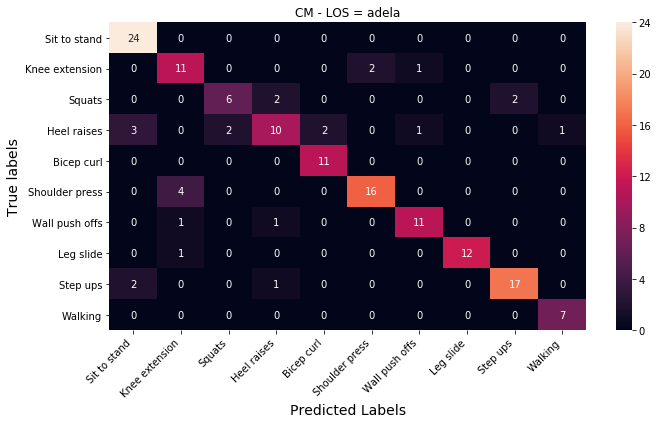

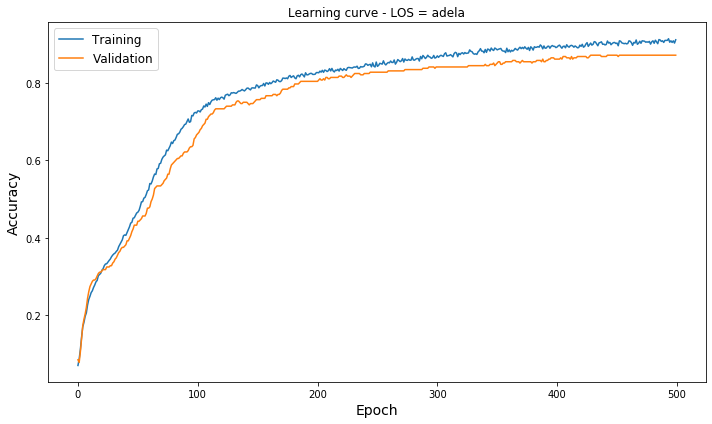

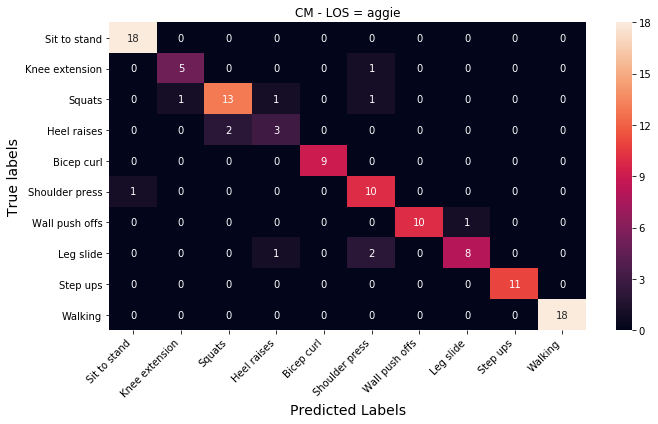

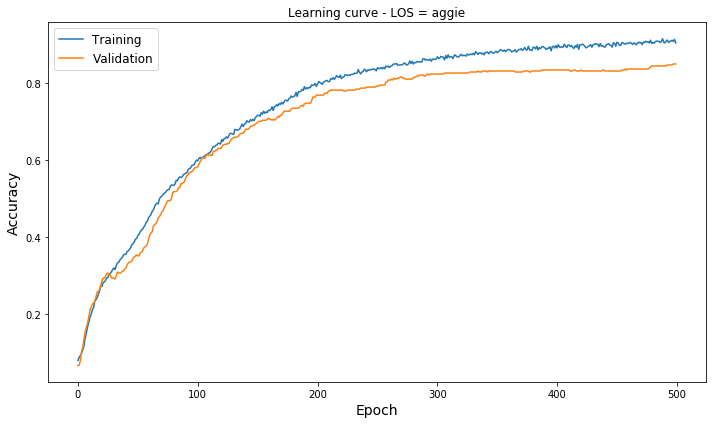

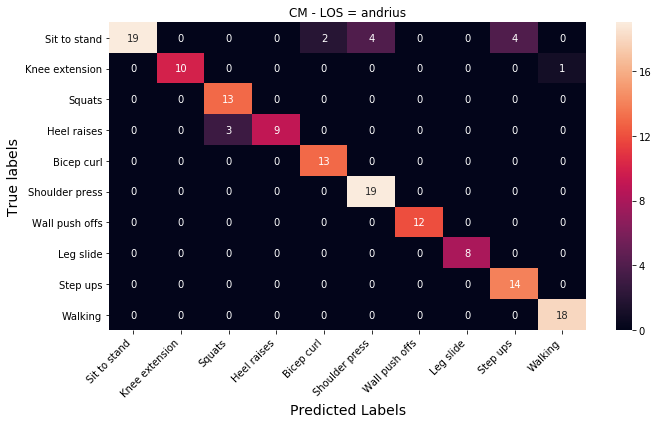

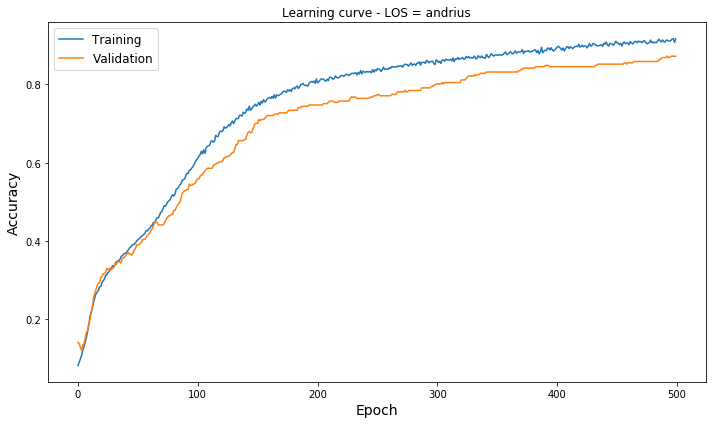

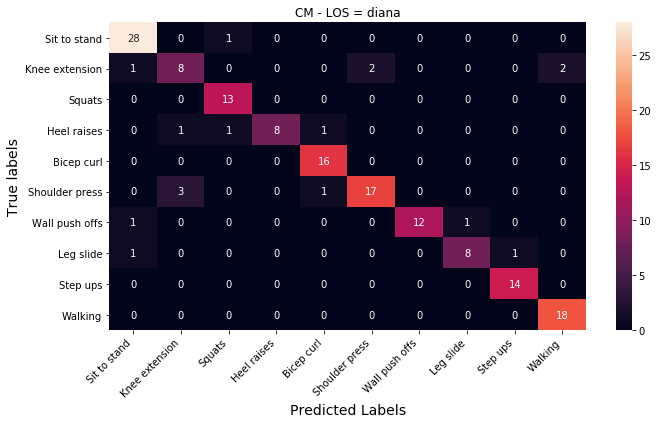

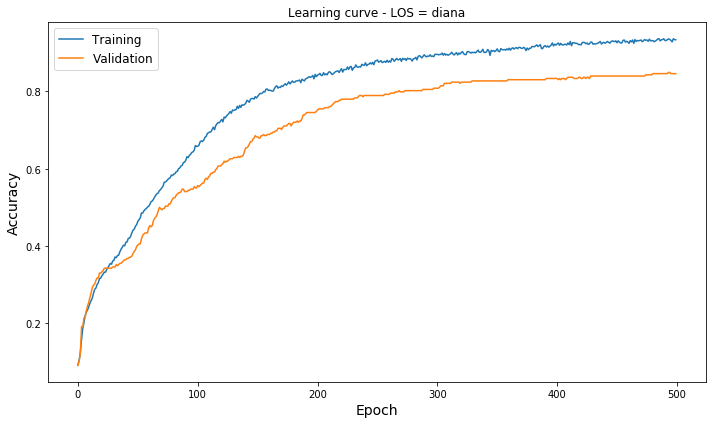

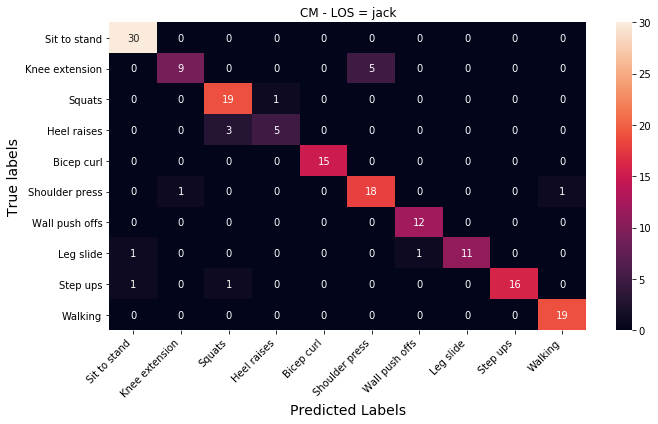

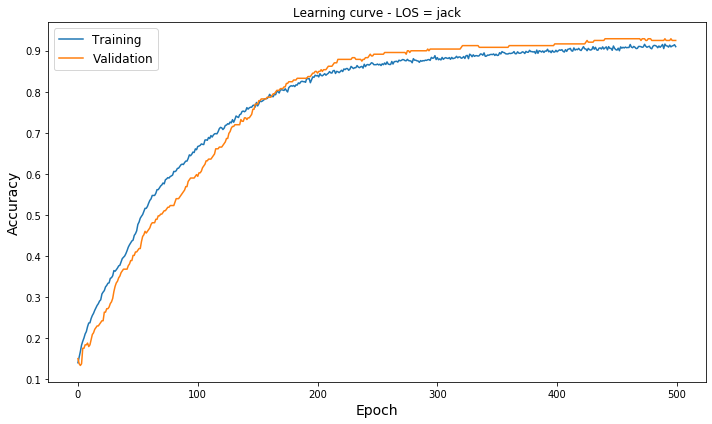

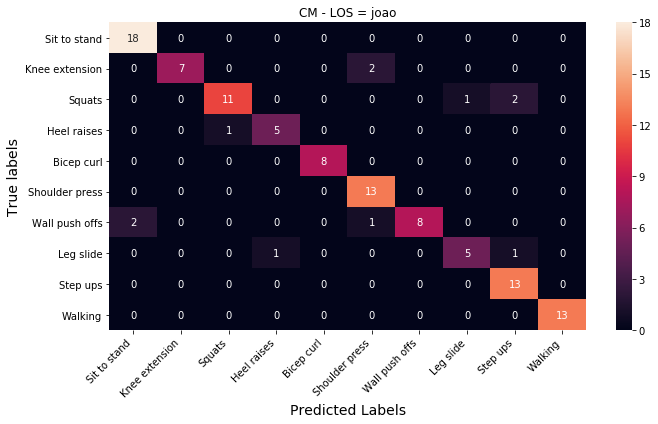

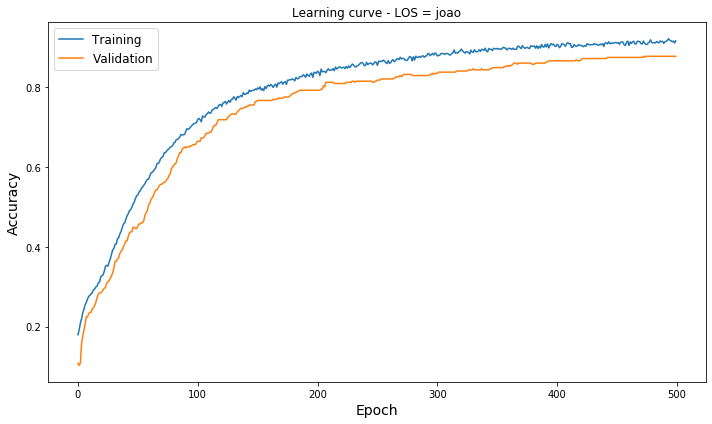

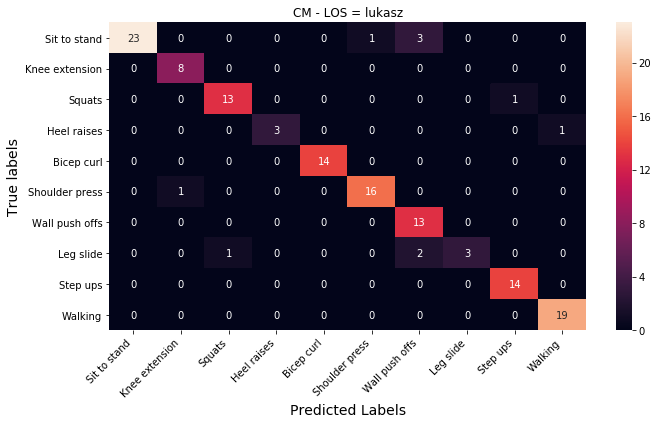

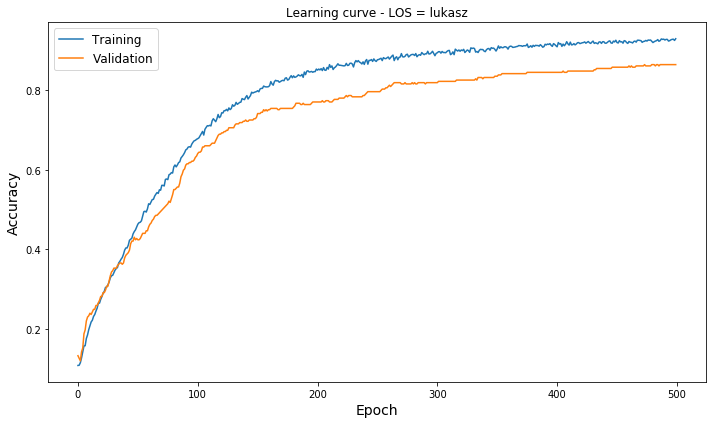

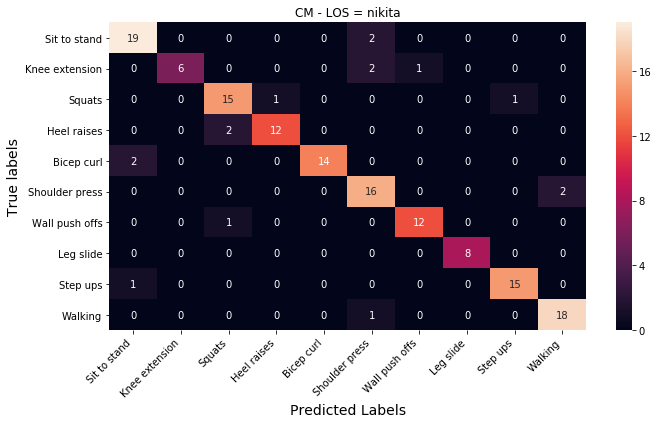

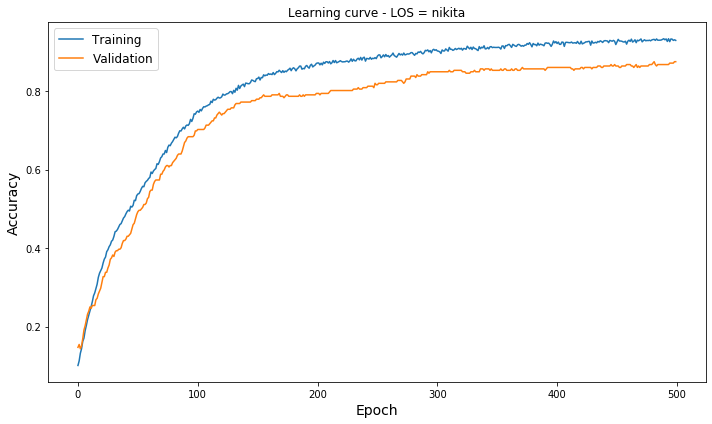

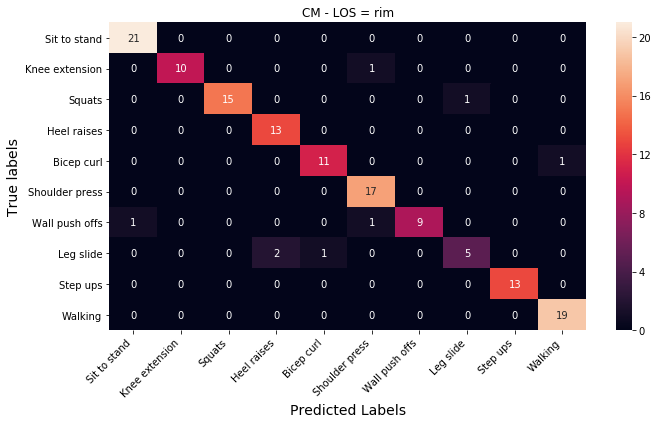

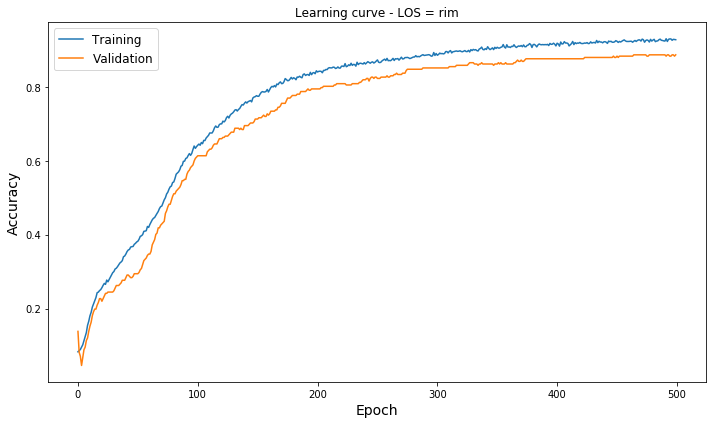

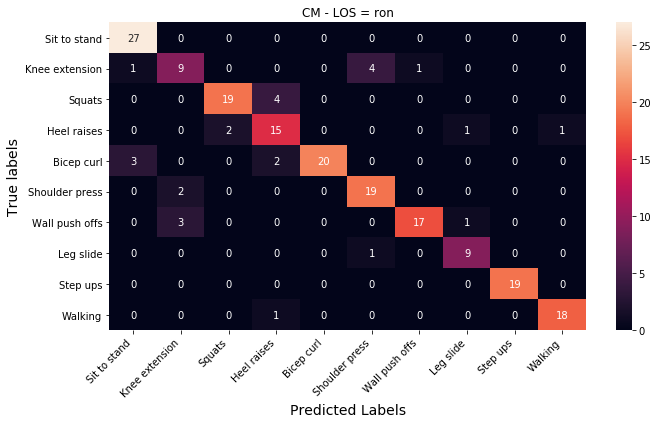

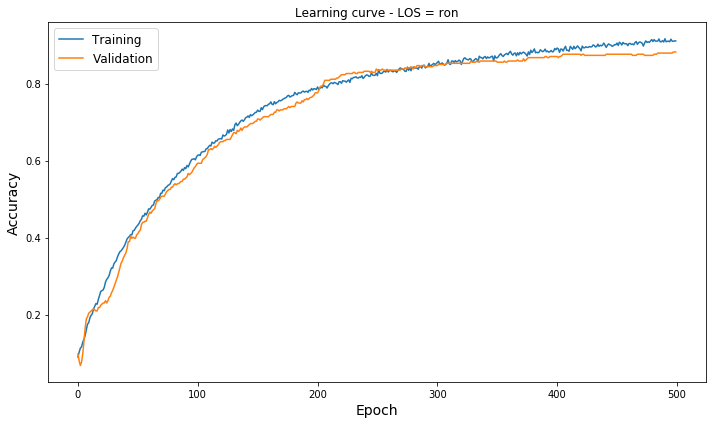

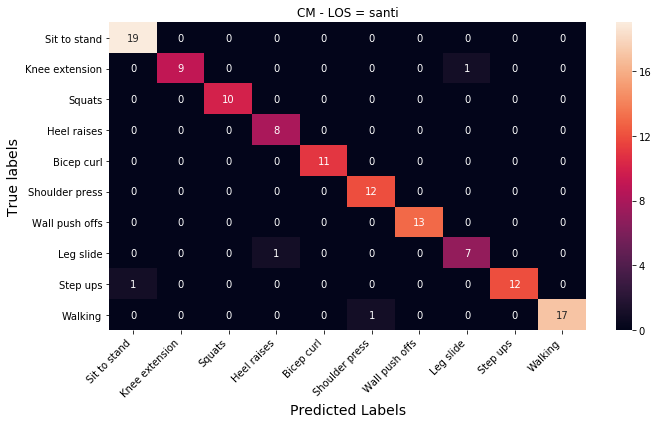

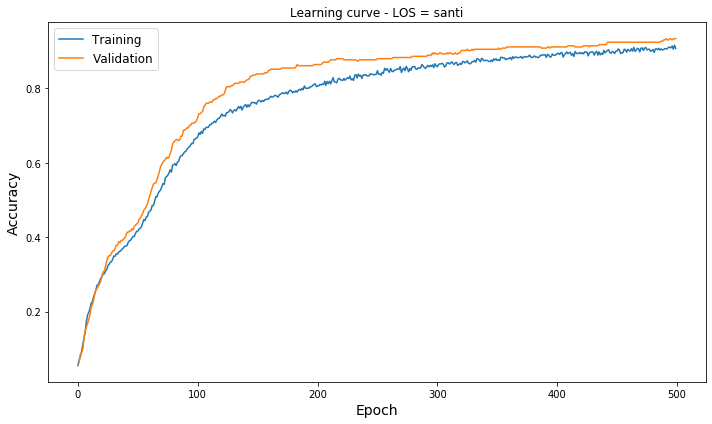

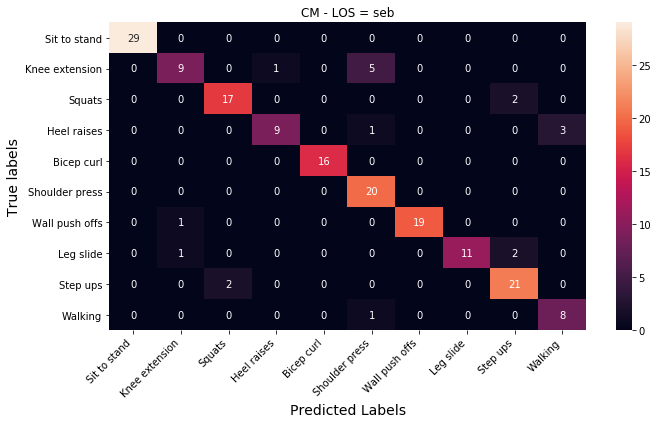

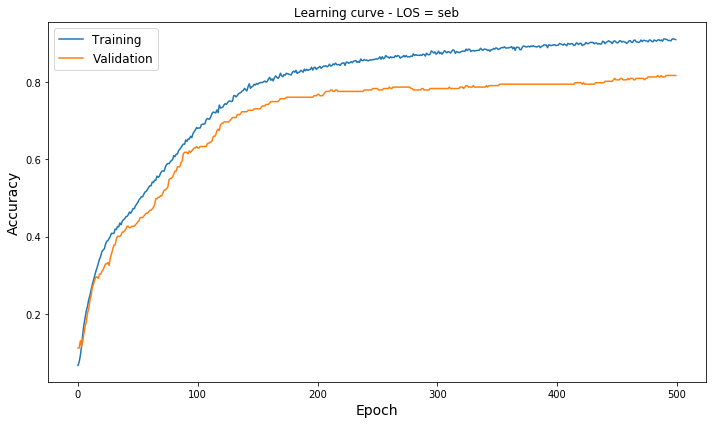

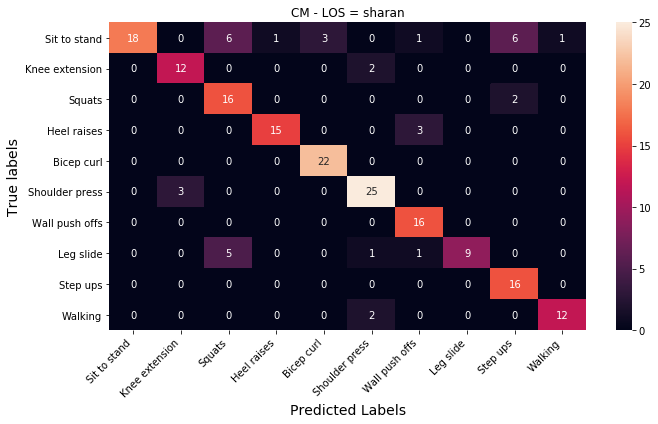

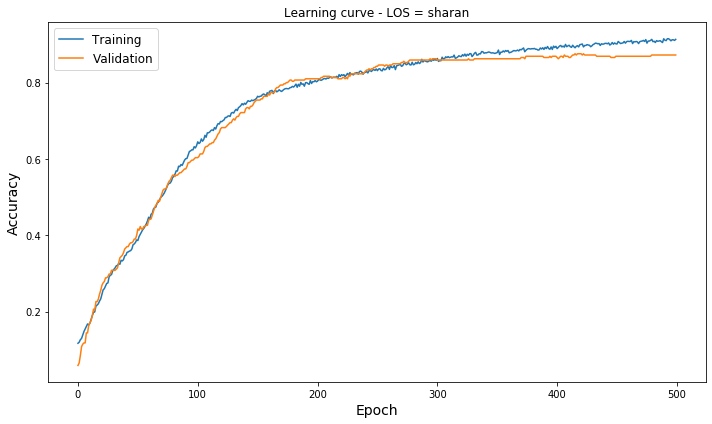

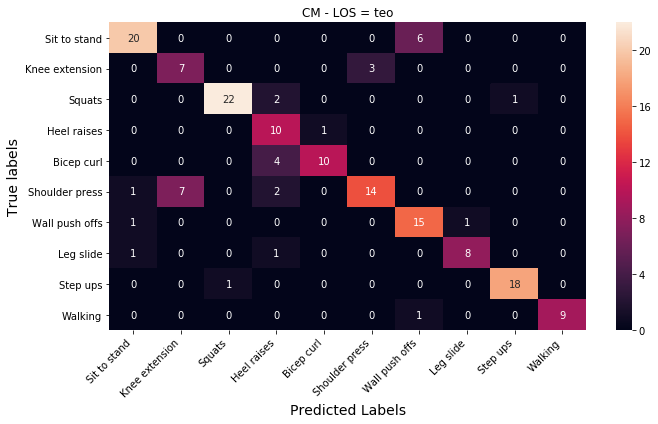

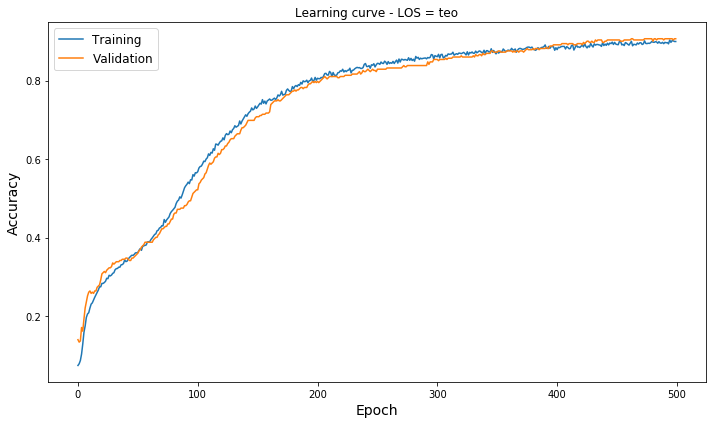

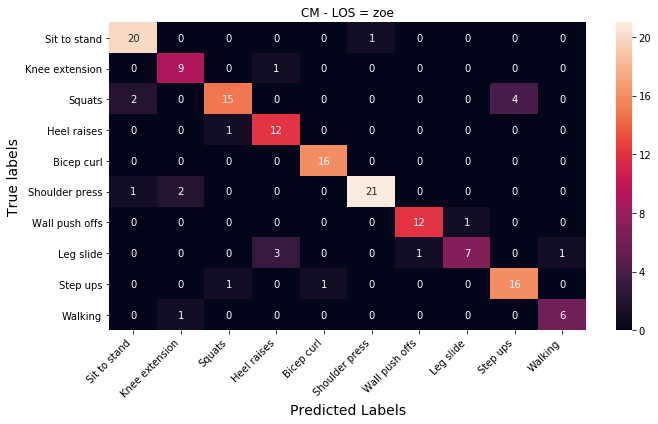

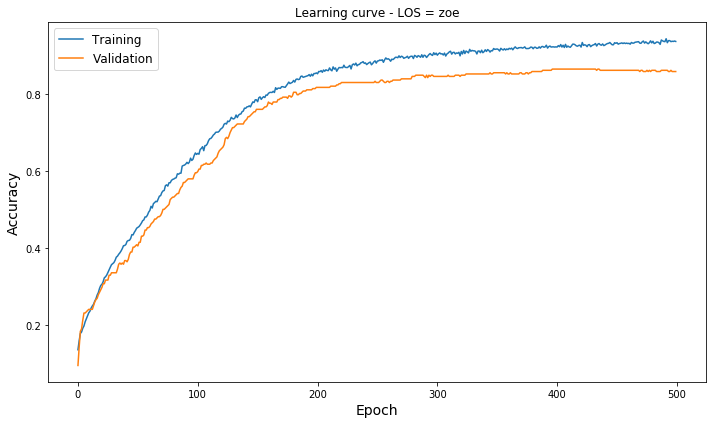

In [62]:
for i in range(len(subjects)):
    
    # early stopping for testing
#     if i > 1:
#         break
    
    # generate training, validation and test subjects
    
    left_out_subject = subjects[i]
    print("Left out subject = {}".format(subjects[i]))
    
    rng = generate_range(i, n_subjects)
    
    train_subjects = set()
    while(len(train_subjects) < n_train_subjects):
        choice = random.choice(rng)
        train_subjects.add(choice)
    
    # for validation, take the remaining ones
    valid_subjects = [subjects[j] for j in (set(rng) - train_subjects)]
    
    train_subjects = [subjects[j] for j in train_subjects]
    
    print("Test subjects = {}".format(train_subjects))
    print("Validation subjects = {}".format(valid_subjects))
    
    train_valid_subjects = train_subjects + valid_subjects
    
    # split the data
    mask_subj = (data['subject'] == train_valid_subjects[0])
    for tvs in train_valid_subjects:
        mask_subj = mask_subj | (data['subject'] == tvs)
        
    data_train = data[mask_subj]
    data_train.reset_index(drop=True, inplace=True)
    
    data_test = data[data['subject'] == left_out_subject]
    data_test.reset_index(drop=True, inplace=True)
    
    print("-" * 80)
    print("Removing outliers")
    print("-" * 80)
    
    # remove outliers for training
    data_train, _, _ = remove_outliers(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # remove outliers for test
    data_test, _, _ = remove_outliers(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Standardising")
    print("-" * 80)
    
    # standardise for training
    data_train = standardise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # standardise for test
    data_test = standardise_data(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Normalising")
    print("-" * 80)
    
    # normalise for training
    data_train, scaler_fit = normalise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # normalise for test
    data_test, _ = normalise_data(data_test, activities=activities, subjects=[left_out_subject], 
                                  correctness=correctness, scaler_fit=scaler_fit)
    
    print("-" * 80)
    print("Generating datasets")
    print("-" * 80)
    
    # Generate datasets
    X_train, y_train = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=train_subjects, correctness=correctness)
    
    X_valid, y_valid = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=valid_subjects, correctness=correctness)
    
    X_test, y_test = generate_dataset(df=data_test, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=[left_out_subject], correctness=correctness)
    
    # create new model
    model = initialise_model()

    # compile model
    model.compile(optimizer=sgd,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'mse'])

    history = model.fit(X_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_valid, y_valid))
    
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    activity_labels = get_activity_label_dict()
    cm_labels = [activity_labels[i] for i in range(10)]

    confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
    fig = plt.figure(figsize=(10, 6))
    ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    plt.ylabel("True labels", fontsize=14)
    plt.title("CM - LOS = {}".format(left_out_subject))
    fig.tight_layout()
    plt.savefig(save_path + "{}_CM_LOS.pdf".format(left_out_subject))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Learning curve - LOS = {}".format(left_out_subject))
    plt.legend(fontsize=12)
    fig.tight_layout()
    plt.savefig(save_path + "{}_LC_LOS.pdf".format(left_out_subject))
    
    # record stats
    losoxv_stats.loc[left_out_subject, 'train_acc'] = history.history['accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'train_loss'] = history.history['loss'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_acc'] = history.history['val_accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_loss'] = history.history['val_loss'][-1]
    
    final_loss, final_acc, final_mse = model.evaluate(X_test, y_test, batch_size)
    print("Final loss = {}".format(final_loss))
    print("Final accuracy = {}".format(final_acc))
    
    losoxv_stats.loc[left_out_subject, 'test_acc'] = final_acc
    losoxv_stats.loc[left_out_subject, 'test_loss'] = final_loss
    
    # update cm and history
    cm[left_out_subject] = confusion_matrix
    histories[left_out_subject] = history

In [64]:
losoxv_stats.to_csv("../Plots/06_LOSOXV/baseline_stats_losoxv.csv")

In [1]:
import pickle
cm = pickle.load(open("../Plots/06_LOSOXV/cms.p", 'rb'))
histories = pickle.load(open("../Plots/06_LOSOXV/histories.p", 'rb'))

Using TensorFlow backend.


In [6]:
cm['adela'] 

array([[24,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  2,  1,  0,  0,  0],
       [ 0,  0,  6,  2,  0,  0,  0,  0,  2,  0],
       [ 3,  0,  2, 10,  2,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  0, 11,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0, 16,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0, 11,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 12,  0,  0],
       [ 2,  0,  0,  1,  0,  0,  0,  0, 17,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7]])

In [9]:
mean_cm = np.zeros(cm['adela'].shape)
for subj in subjects:
    mean_cm += cm[subj]

mean_cm /= len(subjects)

In [10]:
mean_cm

array([[22.2       ,  0.        ,  0.46666667,  0.06666667,  0.33333333,
         0.53333333,  0.66666667,  0.        ,  0.66666667,  0.06666667],
       [ 0.13333333,  8.6       ,  0.        ,  0.13333333,  0.        ,
         1.93333333,  0.2       ,  0.06666667,  0.        ,  0.2       ],
       [ 0.13333333,  0.06666667, 14.46666667,  0.73333333,  0.        ,
         0.06666667,  0.        ,  0.13333333,  1.        ,  0.        ],
       [ 0.2       ,  0.06666667,  1.13333333,  9.13333333,  0.26666667,
         0.06666667,  0.26666667,  0.06666667,  0.        ,  0.4       ],
       [ 0.33333333,  0.        ,  0.        ,  0.4       , 13.73333333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.06666667],
       [ 0.2       ,  1.53333333,  0.        ,  0.13333333,  0.06666667,
        16.86666667,  0.        ,  0.        ,  0.        ,  0.2       ],
       [ 0.33333333,  0.33333333,  0.06666667,  0.06666667,  0.        ,
         0.13333333, 12.73333333,  0.33333333

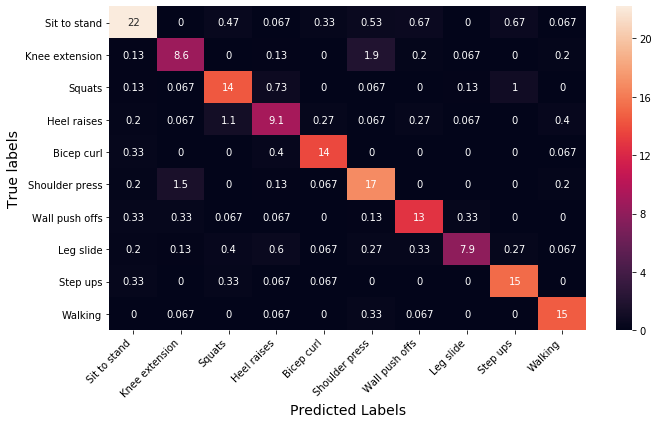

In [12]:
activity_labels = get_activity_label_dict()
cm_labels = [activity_labels[i] for i in range(10)]

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(mean_cm, xticklabels=cm_labels, yticklabels=cm_labels, annot=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.ylabel("True labels", fontsize=14)
fig.tight_layout()
plt.savefig("../Plots/06_LOSOXV/mean_cm_losoxv.pdf")

In [85]:
training_lines = []
validation_lines = []

for subj in subjects:
    training_lines.append(histories[subj].history['accuracy'])
    validation_lines.append(histories[subj].history['val_accuracy'])

training_lines = np.asarray(training_lines)
validation_lines = np.asarray(validation_lines)

In [90]:
# mean and std of the learning curves
training_mean = np.mean(training_lines, axis=0)
validation_mean = np.mean(validation_lines, axis=0)

training_std = np.std(training_lines, axis=0)
validation_std = np.std(validation_lines, axis=0)

print(training_mean.shape)

(500,)


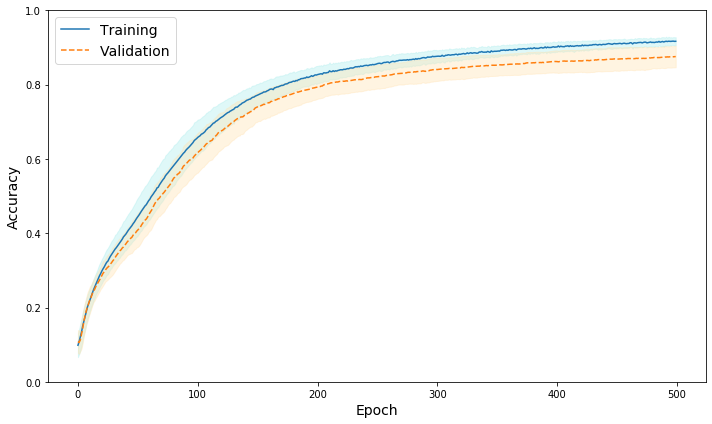

In [117]:
fig = plt.figure(figsize=(10,6))
plt.plot(training_mean, label='Training')
plt.plot(validation_mean, '--', label='Validation')

# Draw bands
plt.fill_between(range(500), training_mean - training_std, training_mean + training_std, color="paleturquoise", alpha=0.4)
plt.fill_between(range(500), validation_mean - validation_std, validation_mean + validation_std, color="moccasin", alpha=0.4)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim((0, 1))
plt.legend(fontsize=14)

fig.tight_layout()
plt.savefig("../Plots/06_LOSOXV/mean_LC_losoxv.pdf")